# Word Vector- Example
This notebook sets up a word vectorization workflow on a toy example. Sentences are made up of spelled-out even and odd numbers.

## Setup
Import necesarry libraries and configure run settings:

In [1]:
import os, math, csv, re, itertools
import numpy as np
import pandas as pd
from collections import Counter
import jellyfish as jyfs
import datetime, time
import pickle
import matplotlib.pyplot as plt

## Corpus

We will import the CAB item description dataset in this section. The names must be contained within a list type object of format:

['Sentence 1', 'Sentence 2', 'Sentence 3']

In [2]:
ItemDescription = {}
i = 0

with open('../Data/Private/CAB_ItemVersion.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ItemDescription[i] = row['ItemDescription']
        i += 1

In [3]:
# Extract list of part descriptions and numbers
ItemDescriptionList = [(v) for k,v in ItemDescription.items()]

## Text Processing
Some light text processing will be performed to remove numbers, punctuation, special characters, whitespace and single-character words.

In [4]:
ItemDescriptionList[0:10]

['AIR CLEANER BAND',
 '2-1/2ODX.250W AL TUBE',
 'AL TUBE 4 OD X .064 W T4',
 '5-1/2ODX.062W AL TUBE',
 '6 OD X.058W AL TUBE',
 '6 OD X.125W AL TUBE',
 '7 OD X.125W AL TUBE',
 'WHEEL SAFETY/SVCE MANUAL',
 'WHL SERV MANUAL-SPANISH',
 'ALUMINUM COIL STOCK (ALL)']

### Basics
Remove all non-letters, whitespace and single characters, lower space.

In [6]:
sentences = [re.sub('[^A-Za-z]', ' ', e) for e in ItemDescriptionList] # Remove all non-letter characters
sentences = [re.sub('\s+', ' ', e).strip().lower() for e in sentences] # Strip excess whitespace
sentences = [' '.join( [w for w in sent.split() if len(w)>1] ) for sent in sentences] # Remove single character "words
sentences[0:10]

['air cleaner band',
 'odx al tube',
 'al tube od',
 'odx al tube',
 'od al tube',
 'od al tube',
 'od al tube',
 'wheel safety svce manual',
 'whl serv manual spanish',
 'aluminum coil stock all']

### Resolve Typos/Abbreviations
The next text processing step is to attempt to remediate misspellings and abbreviations with string matching patterns. First step is to generate a list of unique words.

First, we need a term frequency list.

In [7]:
wordList = " ".join(sentences).split()
counts = Counter(wordList)

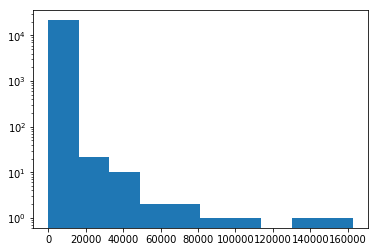

In [8]:
# Make a data frame of words, their counts, and original/new index values (not yet modified)

## Convert counter to data frame
wordcount = pd.DataFrame.from_dict(counts, orient='index').reset_index()
wordcount = wordcount.rename(columns={'index':'word', 0:'count'})
## Sort in descending order of count and reset index
wordcount = wordcount.sort_values('count', ascending=False).reset_index(drop = True)
## Copy index into original and new index columns
wordcount['og_index'] = wordcount['new_index'] = wordcount.index.values
wordcount['new_word'] = wordcount['word']

# Check it out
plt.hist(wordcount['count'])
plt.yscale('log', nonposy='clip')
plt.show()

Now we iterate down the list and examine Jaro Winkler distances as we go. If a distance is above our threshold, we update the "new index" value to the match.

In [ ]:
# Prep word matrices
originalWords = wordcount.copy()
condensedWords = pd.DataFrame()
scores = []

# Set distance threshold
def distanceSet(currentCount, maxCount, baseline = 0.9):
    # This function sets a logarithmically increasing Jaro-Winkler distance threshold
    # based on the number of occurences of a word in the corpus.
    threshold = baseline + ((math.log(currentCount) / math.log(maxCount)) / (1/(1 - baseline)))
    return threshold


# Initialize loop parameters
cont_iteration = (len(originalWords) >= 1)

while cont_iteration == True:
    # Pop top word from originalWords
    originalWords, targetRecord = originalWords.drop(originalWords.head(1).index),originalWords.head(1)
    
    # Score against condensed newWords
    ## Pull out the targetWord
    targetWord = targetRecord.iloc[0]['word']
    targetIndex = targetRecord.iloc[0]['og_index']
    targetCount = targetRecord.iloc[0]['count']
    distanceThreshold = distanceSet(currentCount = targetCount, maxCount = 163000, baseline = 0.9)
    
    ## Score against condensed word list (if it exists)    
    if len(condensedWords) > 0:
        scores = [jyfs.jaro_winkler(targetWord, comp) for comp in condensedWords['new_word']]
        
        ## If a score has passed the threshold, update record with the new word
        if max(scores) >= distanceThreshold:
            ## Get the index of the match
            matchPointer = scores.index(max(scores))
            
            ## Create a new targetRecord with the match
            matchWord = condensedWords.iloc[matchPointer]['new_word']
            matchIndex = condensedWords.iloc[matchPointer]['new_index']
            print("Match found: Target-", targetWord, " Match-", matchWord)
            targetRecord = pd.DataFrame({'word': targetWord,
                                                'new_word': matchWord,
                                                'og_index': int(targetIndex),
                                                'new_index': int(matchIndex)},
                                        index = [0])
    
    # Append to condensed words
    condensedWords = condensedWords.append(targetRecord)
    
    # Reset iteration checker
    cont_iteration = (len(originalWords) >= 1)
    
    # Status update
    if len(condensedWords) % 100 == 0:
        print("Completed: ", len(condensedWords))
        print("Distance Threshold: ", distanceThreshold)
        print("================================================")

Now save the results to a CSV and a pickle.

In [10]:
# condensedWords.to_csv("./tempfiles/condensedWords.csv")
condensedWords_filename = ("./tempfiles/condensedWords_final.p")
# condensedWords.to_pickle(condensedWords_filename)
condensedWords = pd.read_pickle(condensedWords_filename)

Next, we need to re-map the part descriptions to use the new words.

In [11]:
# Build the replacement map using original words as indeces
wordReplacement_map = {}

for record in range(0, (len(condensedWords))):
    old_word = condensedWords.iloc[record]['word']
    new_word = condensedWords.iloc[record]['new_word']
    wordReplacement_map[old_word] = new_word

In [12]:
# Apply mappings to sentences using the above map.
## Initiate an empty list to catch the new sentences
new_sentences = []

## Loop through sentences and replace words
for sent in sentences:
    # Tokenize the sentence
    tokenized_sent = sent.split()
    
    # Prep an empty sentence to reconstruct the tokenized sentence with new words
    temp_sent = []
    
    # Rebuild the sentence using the word-new word map
    [temp_sent.append(wordReplacement_map[word]) for word in tokenized_sent]
    # Join the sentence
    temp_sent = " ".join(temp_sent)
    # Append the new sentence to the new_sentence list
    new_sentences.append(temp_sent)

### Drop Infrequent Terms
Filter out words below an occurence threshold. We will apply this filter to our sentences by replacing "new_word" in our wordReplacement_map dict with a blank.

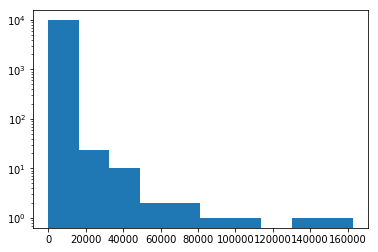

In [17]:
# Extract the new words into a list, then count the occurences
newWordList = " ".join(new_sentences).split()
newCounts = Counter(newWordList)

## Convert counter to data frame and sort occurence
newwordcount = pd.DataFrame.from_dict(newCounts, orient='index').reset_index()
newwordcount = newwordcount.rename(columns={'index':'word', 0:'count'})
## Sort in descending order of count and reset index
newwordcount = newwordcount.sort_values('count', ascending=False).reset_index(drop = True)
## Check it out
newwordcount.head()

# Build a word to frequency map
wordFreq_map = {}
## Generate new list using word as key and count as value
for record in range(0, (len(newwordcount))):
    word = newwordcount.iloc[record]['word']
    count = newwordcount.iloc[record]['count']
    wordFreq_map[word] = count
    
plt.hist(newwordcount['count'])
plt.yscale('log', nonposy='clip')
plt.show()

Now that we have a map of word-to-frequency, let's run back through the sentences and drop words below some occurence threshold.

In [18]:
# Apply mappings to sentences using the above map.
## Initiate an empty list to catch the new sentences
final_sentences = []
## Set a threshold for occurence
occurence_threshold = 100

## Loop through sentences and replace words
for sent in new_sentences:
    # Tokenize the sentence
    tokenized_sent = sent.split()
    
    # Prep an empty sentence to reconstruct the tokenized sentence with only frequent terms
    temp_sent = []
    
    # Loop through each word in the sentence
    for word in tokenized_sent:
        # Get the word frequency
        word_freq = wordFreq_map[word]
        # Add word back into sentence only if it passes the threshold for freq.
        if word_freq >= occurence_threshold:
            temp_sent.append(word)
        else:
            print("Dropping word:", word, "with frequency ", word_freq)
    
    # Make sure that we didn't remove all words from a sentence. If we did, we will use the original sentence
    if len(temp_sent) == 0:
        temp_sent = tokenized_sent
        print("Word drop override")

    # Collapse tokenized sentence
    temp_sent = " ".join(temp_sent)
    # Join to final sentences list
    final_sentences.append(temp_sent)

Dropping word: svce with frequency  32
Dropping word: stock with frequency  64
Dropping word: avk with frequency  79
Dropping word: avk with frequency  79
Dropping word: clench with frequency  18
Dropping word: avk with frequency  79
Dropping word: diapattern with frequency  3
Dropping word: coupler with frequency  89
Dropping word: expanded with frequency  40
Dropping word: trouble with frequency  4
Dropping word: timbren with frequency  8
Dropping word: aeon with frequency  17
Dropping word: doser with frequency  55
Dropping word: siso with frequency  75
Dropping word: dosing with frequency  79
Dropping word: spherical with frequency  80
Dropping word: spherical with frequency  80
Dropping word: beta with frequency  20
Dropping word: mixing with frequency  63
Dropping word: dosing with frequency  79
Dropping word: legris with frequency  89
Dropping word: legris with frequency  89
Dropping word: te with frequency  47
Dropping word: legris with frequency  89
Dropping word: legris with 

Dropping word: tem with frequency  63
Dropping word: gps with frequency  88
Dropping word: arden with frequency  55
Dropping word: grote with frequency  77
Dropping word: cds with frequency  22
Dropping word: mechanical with frequency  88
Word drop override
Dropping word: hayden with frequency  38
Dropping word: dosing with frequency  79
Dropping word: airleaf with frequency  12
Dropping word: align with frequency  33
Dropping word: align with frequency  33
Dropping word: palnut with frequency  33
Dropping word: sail with frequency  25
Dropping word: snubber with frequency  36
Dropping word: htm with frequency  27
Dropping word: tpr with frequency  42
Dropping word: thr with frequency  58
Dropping word: ptf with frequency  19
Dropping word: fir with frequency  47
Dropping word: overflow with frequency  76
Dropping word: overflow with frequency  76
Dropping word: neoprene with frequency  63
Dropping word: see with frequency  59
Word drop override
Dropping word: southco with frequency  2

Dropping word: oper with frequency  87
Dropping word: frg with frequency  89
Dropping word: frg with frequency  89
Dropping word: frg with frequency  89
Dropping word: frg with frequency  89
Dropping word: frg with frequency  89
Dropping word: frg with frequency  89
Dropping word: frg with frequency  89
Dropping word: tem with frequency  63
Dropping word: gps with frequency  88
Dropping word: arden with frequency  55
Dropping word: grote with frequency  77
Dropping word: airleaf with frequency  12
Dropping word: align with frequency  33
Dropping word: align with frequency  33
Dropping word: palnut with frequency  33
Dropping word: hngr with frequency  36
Dropping word: sail with frequency  25
Dropping word: hngr with frequency  36
Dropping word: snubber with frequency  36
Dropping word: worm with frequency  29
Dropping word: htm with frequency  27
Dropping word: ptf with frequency  19
Dropping word: fir with frequency  47
Dropping word: overflow with frequency  76
Dropping word: southc

Dropping word: stover with frequency  22
Dropping word: sho with frequency  8
Dropping word: mdcc with frequency  10
Dropping word: cbo with frequency  8
Dropping word: mdcc with frequency  10
Dropping word: cbo with frequency  8
Dropping word: scratch with frequency  5
Dropping word: bpr with frequency  61
Dropping word: bpr with frequency  61
Dropping word: bpr with frequency  61
Dropping word: plywood with frequency  16
Word drop override
Dropping word: airdryer with frequency  80
Dropping word: hdp with frequency  59
Dropping word: dtm with frequency  71
Dropping word: junct with frequency  78
Dropping word: fci with frequency  32
Dropping word: apex with frequency  47
Dropping word: fci with frequency  32
Dropping word: fci with frequency  32
Dropping word: rke with frequency  50
Dropping word: backshell with frequency  8
Dropping word: hdp with frequency  59
Dropping word: weather with frequency  82
Dropping word: dtm with frequency  71
Dropping word: bit with frequency  22
Dropp

Dropping word: ends with frequency  30
Dropping word: corp with frequency  52
Dropping word: prod with frequency  13
Dropping word: traceability with frequency  16
Dropping word: zytel with frequency  32
Dropping word: mold with frequency  90
Dropping word: cstg with frequency  12
Dropping word: corp with frequency  52
Dropping word: foil with frequency  8
Dropping word: product with frequency  16
Dropping word: traceability with frequency  16
Dropping word: cj with frequency  27
Dropping word: omnivision with frequency  53
Dropping word: omnivision with frequency  53
Dropping word: omnivision with frequency  53
Dropping word: omnivision with frequency  53
Dropping word: omnivision with frequency  53
Dropping word: omnivision with frequency  53
Dropping word: omnivision with frequency  53
Dropping word: omnivision with frequency  53
Dropping word: omnivision with frequency  53
Dropping word: omnivision with frequency  53
Dropping word: conspicuity with frequency  79
Dropping word: cons

Dropping word: wood with frequency  41
Dropping word: rain with frequency  85
Dropping word: unistrap with frequency  15
Dropping word: unistrap with frequency  15
Dropping word: cpf with frequency  18
Dropping word: cpf with frequency  18
Dropping word: sieo with frequency  39
Dropping word: cell with frequency  60
Dropping word: cell with frequency  60
Dropping word: final with frequency  52
Dropping word: mfg with frequency  51
Dropping word: envelope with frequency  8
Word drop override
Dropping word: boxes with frequency  5
Dropping word: patent with frequency  59
Dropping word: dfh with frequency  11
Word drop override
Dropping word: ref with frequency  90
Dropping word: indent with frequency  12
Dropping word: fmvss with frequency  40
Dropping word: fmvss with frequency  40
Dropping word: certification with frequency  69
Dropping word: mfgr with frequency  10
Dropping word: shrink with frequency  67
Dropping word: compliance with frequency  31
Dropping word: final with frequency

Dropping word: coupler with frequency  89
Dropping word: flng with frequency  47
Dropping word: tooth with frequency  80
Dropping word: acorn with frequency  72
Dropping word: flangeform with frequency  28
Dropping word: deburred with frequency  26
Dropping word: shrink with frequency  67
Dropping word: shrink with frequency  67
Dropping word: shrink with frequency  67
Dropping word: gre with frequency  12
Dropping word: alli with frequency  80
Dropping word: messenger with frequency  39
Dropping word: loop with frequency  94
Dropping word: aerolatch with frequency  13
Dropping word: flexible with frequency  92
Dropping word: shoulder with frequency  96
Dropping word: trkg with frequency  72
Dropping word: consp with frequency  92
Dropping word: consp with frequency  92
Dropping word: material with frequency  81
Dropping word: damping with frequency  46
Dropping word: rods with frequency  31
Dropping word: odometer with frequency  24
Dropping word: material with frequency  81
Dropping 

Dropping word: clad with frequency  99
Dropping word: clad with frequency  99
Dropping word: resist with frequency  93
Dropping word: hdp with frequency  59
Dropping word: mqs with frequency  5
Dropping word: unsealed with frequency  42
Dropping word: diode with frequency  92
Dropping word: backbone with frequency  74
Dropping word: powertrain with frequency  36
Dropping word: powertrain with frequency  36
Dropping word: hyb with frequency  57
Dropping word: hyb with frequency  57
Dropping word: hy with frequency  32
Dropping word: hy with frequency  32
Dropping word: hy with frequency  32
Dropping word: hy with frequency  32
Dropping word: hy with frequency  32
Dropping word: alli with frequency  80
Dropping word: xm with frequency  49
Dropping word: virt with frequency  20
Dropping word: engn with frequency  74
Dropping word: ulsd with frequency  42
Dropping word: king with frequency  92
Dropping word: riley with frequency  3
Dropping word: conversion with frequency  61
Dropping word

Dropping word: function with frequency  51
Dropping word: rtrdr with frequency  49
Dropping word: used with frequency  42
Dropping word: rtrdr with frequency  49
Dropping word: rtrdr with frequency  49
Dropping word: crse with frequency  12
Dropping word: clk with frequency  71
Dropping word: obdiag with frequency  16
Dropping word: tmr with frequency  66
Dropping word: languages with frequency  48
Dropping word: dtl with frequency  17
Dropping word: trp with frequency  42
Dropping word: econ with frequency  66
Dropping word: trp with frequency  42
Dropping word: menu with frequency  97
Dropping word: wrp with frequency  15
Dropping word: dm with frequency  96
Dropping word: dm with frequency  96
Dropping word: delay with frequency  65
Dropping word: dm with frequency  96
Dropping word: dim with frequency  70
Dropping word: filt with frequency  85
Dropping word: filt with frequency  85
Dropping word: alsn with frequency  16
Dropping word: frw with frequency  32
Dropping word: frw with 

Dropping word: sus with frequency  87
Dropping word: metg with frequency  25
Dropping word: pil with frequency  21
Dropping word: mtl with frequency  28
Dropping word: shrink with frequency  67
Dropping word: natural with frequency  91
Dropping word: ldws with frequency  80
Dropping word: takata with frequency  9
Dropping word: keyed with frequency  41
Dropping word: alike with frequency  62
Dropping word: snsr with frequency  83
Dropping word: esoc with frequency  12
Dropping word: hrpo with frequency  25
Dropping word: extensht with frequency  4
Word drop override
Dropping word: ldws with frequency  80
Dropping word: crvd with frequency  25
Dropping word: ldws with frequency  80
Dropping word: crvd with frequency  25
Dropping word: medallion with frequency  85
Dropping word: wrn with frequency  45
Dropping word: mercury with frequency  38
Dropping word: batteries with frequency  27
Dropping word: king with frequency  92
Dropping word: mll with frequency  45
Dropping word: fso with fr

Dropping word: rockereaton with frequency  6
Dropping word: rockereaton with frequency  6
Dropping word: distribution with frequency  73
Dropping word: rem with frequency  73
Dropping word: vic with frequency  13
Dropping word: interlock with frequency  76
Dropping word: snsr with frequency  83
Dropping word: vic with frequency  13
Dropping word: unitchange with frequency  14
Dropping word: copper with frequency  43
Dropping word: dot with frequency  63
Dropping word: specific with frequency  29
Dropping word: vhb with frequency  51
Dropping word: glvbox with frequency  8
Dropping word: ppc with frequency  10
Dropping word: cylindrical with frequency  3
Dropping word: bridging with frequency  2
Dropping word: smoke with frequency  7
Dropping word: fixation with frequency  2
Dropping word: aircomp with frequency  6
Dropping word: nylock with frequency  48
Dropping word: vibration with frequency  35
Dropping word: shoulder with frequency  96
Dropping word: shoulder with frequency  96
Dro

Dropping word: crnr with frequency  85
Dropping word: griffith with frequency  28
Dropping word: pine with frequency  23
Dropping word: har with frequency  87
Dropping word: jackshaft with frequency  84
Dropping word: tvx with frequency  3
Dropping word: fgt with frequency  23
Dropping word: brute with frequency  58
Dropping word: stock with frequency  64
Dropping word: tierod with frequency  97
Dropping word: transducer with frequency  76
Dropping word: messenger with frequency  39
Dropping word: psh with frequency  30
Dropping word: metg with frequency  25
Dropping word: airshield with frequency  66
Dropping word: messenger with frequency  39
Dropping word: inr with frequency  8
Dropping word: pac with frequency  67
Dropping word: airshield with frequency  66
Dropping word: crankshaft with frequency  31
Dropping word: overhead with frequency  91
Dropping word: overhead with frequency  91
Dropping word: pmp with frequency  46
Dropping word: prs with frequency  67
Dropping word: metg w

Dropping word: stab with frequency  55
Dropping word: veeder with frequency  93
Dropping word: interlock with frequency  76
Dropping word: mdflp with frequency  27
Dropping word: mdflp with frequency  27
Dropping word: behr with frequency  27
Dropping word: xd with frequency  35
Dropping word: mol with frequency  18
Dropping word: intercooler with frequency  3
Dropping word: cablecraft with frequency  17
Dropping word: sander with frequency  43
Dropping word: natural with frequency  91
Dropping word: delta with frequency  22
Dropping word: gus with frequency  17
Dropping word: gu with frequency  24
Dropping word: mtrc with frequency  14
Dropping word: ap with frequency  67
Dropping word: prs with frequency  67
Dropping word: middle with frequency  80
Dropping word: obd with frequency  53
Dropping word: flthd with frequency  26
Dropping word: ms with frequency  95
Dropping word: fhen with frequency  56
Dropping word: biodiesel with frequency  1
Dropping word: freedomline with frequency 

Dropping word: lgth with frequency  21
Dropping word: solution with frequency  6
Dropping word: cleaning with frequency  8
Dropping word: cassette with frequency  71
Word drop override
Dropping word: cobra with frequency  87
Dropping word: sockcapscrew with frequency  4
Word drop override
Dropping word: plc with frequency  37
Dropping word: extinguisher with frequency  81
Dropping word: monroe with frequency  16
Dropping word: ranco with frequency  6
Dropping word: ecas with frequency  31
Dropping word: ecas with frequency  31
Dropping word: transducer with frequency  76
Dropping word: expansion with frequency  19
Dropping word: adep with frequency  1
Dropping word: clipping with frequency  8
Dropping word: mmorfs with frequency  15
Dropping word: enbl with frequency  4
Dropping word: ndl with frequency  19
Dropping word: drier with frequency  91
Dropping word: drier with frequency  91
Dropping word: lhd with frequency  52
Dropping word: expansion with frequency  19
Dropping word: cond

Dropping word: magsw with frequency  5
Dropping word: intduty with frequency  1
Word drop override
Dropping word: between with frequency  8
Dropping word: pinplug with frequency  1
Dropping word: keeper with frequency  56
Dropping word: send with frequency  93
Dropping word: audible with frequency  26
Dropping word: buzzer with frequency  87
Dropping word: uni with frequency  61
Dropping word: send with frequency  93
Dropping word: butt with frequency  64
Dropping word: nnector with frequency  23
Word drop override
Dropping word: lug with frequency  96
Dropping word: gota with frequency  6
Dropping word: stu with frequency  11
Dropping word: hobbs with frequency  26
Dropping word: swgd with frequency  92
Dropping word: mkr with frequency  34
Dropping word: spotlight with frequency  81
Dropping word: gax with frequency  54
Dropping word: idx with frequency  78
Dropping word: grom with frequency  57
Dropping word: grn with frequency  86
Dropping word: indent with frequency  12
Word drop 

Dropping word: nn with frequency  10
Dropping word: toolcmpt with frequency  27
Dropping word: toolcmpt with frequency  27
Dropping word: kern with frequency  10
Dropping word: vet with frequency  8
Dropping word: less with frequency  18
Dropping word: sealant with frequency  90
Dropping word: nfx with frequency  89
Dropping word: matt with frequency  50
Dropping word: anch with frequency  70
Word drop override
Dropping word: toolcmpt with frequency  27
Dropping word: ledge with frequency  75
Dropping word: ledge with frequency  75
Dropping word: matt with frequency  50
Dropping word: binding with frequency  94
Dropping word: bhd with frequency  61
Dropping word: seatbase with frequency  9
Dropping word: cums with frequency  26
Dropping word: buffer with frequency  50
Dropping word: pulse with frequency  73
Dropping word: aii with frequency  59
Dropping word: peek with frequency  5
Dropping word: idx with frequency  78
Dropping word: jb with frequency  31
Dropping word: catpeec with fr

Dropping word: opposed with frequency  35
Dropping word: ver with frequency  66
Dropping word: fwdlwr with frequency  3
Dropping word: nonaeromirror with frequency  3
Dropping word: fwdupr with frequency  2
Dropping word: nonaeromirror with frequency  3
Dropping word: fwdupr with frequency  2
Dropping word: nonaeromirror with frequency  3
Dropping word: fwdlwr with frequency  3
Dropping word: nonair with frequency  16
Dropping word: nonair with frequency  16
Dropping word: albaseal with frequency  6
Dropping word: permagum with frequency  4
Dropping word: pcv with frequency  1
Dropping word: utility with frequency  56
Dropping word: tether with frequency  94
Dropping word: airglide with frequency  55
Dropping word: doc with frequency  30
Dropping word: dvd with frequency  32
Dropping word: pwrdistbox with frequency  32
Dropping word: pollak with frequency  54
Dropping word: intermittent with frequency  45
Dropping word: route with frequency  65
Dropping word: easy with frequency  36
Dr

Dropping word: cnvtb with frequency  21
Dropping word: tripodometer with frequency  1
Dropping word: miler with frequency  24
Dropping word: tenna with frequency  27
Dropping word: southco with frequency  23
Dropping word: oilfill with frequency  40
Word drop override
Dropping word: shr with frequency  22
Dropping word: ud with frequency  14
Dropping word: glow with frequency  14
Dropping word: xfstr with frequency  9
Dropping word: oring with frequency  67
Dropping word: airclnr with frequency  15
Dropping word: cruz with frequency  34
Dropping word: cruz with frequency  34
Dropping word: cellular with frequency  23
Dropping word: phone with frequency  98
Dropping word: transceiver with frequency  5
Dropping word: repl with frequency  33
Dropping word: gvsxa with frequency  2
Dropping word: walnut with frequency  87
Dropping word: tubeless with frequency  76
Dropping word: walnut with frequency  87
Dropping word: ldrds with frequency  1
Dropping word: ms with frequency  95
Dropping wo

Dropping word: capscrew with frequency  95
Word drop override
Dropping word: vnut with frequency  10
Word drop override
Dropping word: helical with frequency  83
Dropping word: current with frequency  6
Dropping word: jeb with frequency  69
Dropping word: fld with frequency  90
Dropping word: bullet with frequency  97
Dropping word: rhl with frequency  75
Dropping word: rhl with frequency  75
Dropping word: freq with frequency  45
Dropping word: matt with frequency  50
Dropping word: machscrew with frequency  1
Dropping word: taptite with frequency  34
Dropping word: mldg with frequency  22
Dropping word: doorhingesleeper with frequency  1
Dropping word: crawl with frequency  15
Dropping word: crawl with frequency  15
Dropping word: huckbolt with frequency  27
Word drop override
Dropping word: matt with frequency  50
Dropping word: stg with frequency  47
Dropping word: matt with frequency  50
Dropping word: vit with frequency  29
Dropping word: drip with frequency  29
Dropping word: cy

Dropping word: roe with frequency  33
Dropping word: roe with frequency  33
Dropping word: roe with frequency  33
Dropping word: ver with frequency  66
Dropping word: cer with frequency  67
Dropping word: thermal with frequency  80
Dropping word: dda with frequency  45
Dropping word: vickers with frequency  43
Dropping word: pulse with frequency  73
Dropping word: generator with frequency  36
Word drop override
Dropping word: tang with frequency  45
Dropping word: pulse with frequency  73
Dropping word: generator with frequency  36
Word drop override
Dropping word: awg with frequency  8
Dropping word: sander with frequency  43
Dropping word: lhfwd with frequency  2
Dropping word: rhaft with frequency  1
Dropping word: lhaft with frequency  1
Dropping word: rhfwd with frequency  3
Dropping word: bergstrom with frequency  39
Dropping word: ryder with frequency  15
Dropping word: ver with frequency  66
Dropping word: ryder with frequency  15
Word drop override
Dropping word: ver with freq

Dropping word: rm with frequency  55
Dropping word: ftr with frequency  14
Dropping word: rm with frequency  55
Dropping word: ftr with frequency  14
Dropping word: oring with frequency  67
Dropping word: rm with frequency  55
Dropping word: ftr with frequency  14
Dropping word: uncx with frequency  40
Dropping word: rm with frequency  55
Dropping word: ftr with frequency  14
Dropping word: donal with frequency  11
Dropping word: bkr with frequency  58
Dropping word: slotted with frequency  71
Dropping word: cdsmls with frequency  13
Dropping word: frng with frequency  59
Dropping word: helical with frequency  83
Dropping word: clr with frequency  66
Dropping word: parchment with frequency  5
Dropping word: freeze with frequency  71
Dropping word: trl with frequency  88
Dropping word: freeze with frequency  71
Dropping word: trl with frequency  88
Dropping word: rls with frequency  78
Dropping word: whll with frequency  91
Dropping word: siegler with frequency  36
Dropping word: epdm w

Dropping word: pneus with frequency  26
Word drop override
Dropping word: wh with frequency  48
Dropping word: wh with frequency  48
Dropping word: wh with frequency  48
Word drop override
Dropping word: sands with frequency  5
Dropping word: furnished with frequency  14
Dropping word: furnished with frequency  14
Dropping word: expstl with frequency  1
Dropping word: heatscreen with frequency  1
Word drop override
Dropping word: sqhd with frequency  23
Dropping word: airglide with frequency  55
Word drop override
Dropping word: sqhd with frequency  23
Dropping word: airglide with frequency  55
Word drop override
Dropping word: sqhd with frequency  23
Dropping word: airglide with frequency  55
Word drop override
Dropping word: sqhd with frequency  23
Dropping word: sqhd with frequency  23
Dropping word: sqhd with frequency  23
Dropping word: rwk with frequency  31
Dropping word: trhdslptapab with frequency  2
Word drop override
Dropping word: packing with frequency  31
Dropping word: r

Dropping word: wilma with frequency  10
Dropping word: wilma with frequency  10
Dropping word: mmsst with frequency  15
Dropping word: wilma with frequency  10
Dropping word: dk with frequency  43
Dropping word: wilma with frequency  10
Dropping word: kie with frequency  21
Dropping word: manstrg with frequency  2
Dropping word: ametek with frequency  18
Dropping word: jm with frequency  16
Dropping word: crim with frequency  12
Dropping word: running with frequency  85
Dropping word: running with frequency  85
Dropping word: alignment with frequency  32
Dropping word: msl with frequency  6
Dropping word: rhr with frequency  70
Dropping word: lhr with frequency  74
Dropping word: nub with frequency  2
Dropping word: mmsst with frequency  15
Dropping word: seatbase with frequency  9
Word drop override
Dropping word: bindpost with frequency  5
Dropping word: binding with frequency  94
Dropping word: gax with frequency  54
Dropping word: blkjmpr with frequency  1
Dropping word: fltcsnkms 

Dropping word: intrigal with frequency  15
Dropping word: airshield with frequency  66
Dropping word: airshield with frequency  66
Dropping word: rv with frequency  35
Dropping word: regal with frequency  52
Dropping word: obs with frequency  18
Dropping word: vinylcloth with frequency  50
Dropping word: rtisf with frequency  1
Dropping word: tbg with frequency  88
Dropping word: jtc with frequency  86
Dropping word: wte with frequency  10
Dropping word: organic with frequency  33
Dropping word: pneus with frequency  26
Word drop override
Dropping word: bkrt with frequency  34
Dropping word: tooth with frequency  80
Dropping word: toyo with frequency  62
Dropping word: gallon with frequency  84
Dropping word: olathe with frequency  1
Dropping word: gp with frequency  56
Dropping word: toyo with frequency  62
Dropping word: silvergrey with frequency  25
Dropping word: silver with frequency  85
Dropping word: tenna with frequency  27
Dropping word: aii with frequency  59
Dropping word: r

Dropping word: hiway with frequency  42
Dropping word: universal with frequency  83
Dropping word: diameter with frequency  12
Dropping word: duplex with frequency  69
Dropping word: pillow with frequency  26
Dropping word: hiway with frequency  42
Dropping word: apsco with frequency  8
Dropping word: lfr with frequency  2
Dropping word: rfr with frequency  3
Dropping word: organic with frequency  33
Dropping word: simplex with frequency  56
Dropping word: shrink with frequency  67
Dropping word: herness with frequency  17
Dropping word: fst with frequency  29
Dropping word: tbls with frequency  72
Dropping word: lrr with frequency  1
Dropping word: rror with frequency  6
Dropping word: whll with frequency  91
Dropping word: whll with frequency  91
Dropping word: bkr with frequency  58
Dropping word: nfx with frequency  89
Word drop override
Dropping word: sil with frequency  96
Dropping word: thomas with frequency  12
Dropping word: thomas with frequency  12
Dropping word: speednut wi

Dropping word: capscrew with frequency  95
Word drop override
Dropping word: capscrew with frequency  95
Word drop override
Dropping word: drier with frequency  91
Dropping word: floorboard with frequency  91
Dropping word: diverter with frequency  33
Dropping word: delivery with frequency  52
Dropping word: midland with frequency  70
Dropping word: wte with frequency  10
Dropping word: bf with frequency  11
Dropping word: spotlight with frequency  81
Dropping word: lhf with frequency  87
Dropping word: rhf with frequency  83
Dropping word: lhr with frequency  74
Dropping word: rhr with frequency  70
Dropping word: spiral with frequency  23
Dropping word: dentada with frequency  3
Dropping word: warmup with frequency  3
Dropping word: warmup with frequency  3
Dropping word: warmer with frequency  55
Dropping word: cassette with frequency  71
Dropping word: crimson with frequency  81
Dropping word: mas with frequency  18
Dropping word: arden with frequency  55
Dropping word: bpr with fr

Dropping word: faros with frequency  24
Dropping word: faros with frequency  24
Dropping word: sin with frequency  38
Dropping word: adju with frequency  32
Dropping word: yugo with frequency  73
Dropping word: tirante with frequency  42
Dropping word: balance with frequency  29
Dropping word: embrague with frequency  80
Dropping word: guia with frequency  25
Dropping word: bisagra with frequency  35
Dropping word: bisagra with frequency  35
Dropping word: fibra with frequency  22
Dropping word: vidrio with frequency  28
Dropping word: tirante with frequency  42
Dropping word: parrilla with frequency  64
Dropping word: parrilla with frequency  64
Dropping word: acondicio with frequency  16
Dropping word: parrilla with frequency  64
Dropping word: parrilla with frequency  64
Dropping word: concha with frequency  16
Dropping word: parrilla with frequency  64
Dropping word: concha with frequency  16
Dropping word: parrilla with frequency  64
Dropping word: concha with frequency  16
Droppi

Dropping word: mbllt with frequency  86
Dropping word: fbllt with frequency  38
Dropping word: insljmp with frequency  11
Word drop override
Dropping word: gax with frequency  54
Word drop override
Dropping word: haz with frequency  11
Dropping word: freudenberg with frequency  1
Dropping word: truckmaster with frequency  12
Dropping word: cutler with frequency  5
Dropping word: translator with frequency  37
Dropping word: alsn with frequency  16
Dropping word: nfx with frequency  89
Dropping word: ingram with frequency  3
Dropping word: slprsubframe with frequency  28
Dropping word: slprsubframe with frequency  28
Dropping word: dtts with frequency  7
Dropping word: panic with frequency  22
Dropping word: message with frequency  54
Dropping word: buzzer with frequency  87
Dropping word: buzzer with frequency  87
Dropping word: silencer with frequency  20
Dropping word: sander with frequency  43
Dropping word: sa with frequency  69
Dropping word: protective with frequency  55
Dropping 

Dropping word: purificador with frequency  66
Dropping word: mot with frequency  47
Dropping word: bomba with frequency  55
Dropping word: hidraul with frequency  44
Dropping word: lampara with frequency  63
Dropping word: indicadores with frequency  24
Dropping word: baja with frequency  13
Dropping word: presion with frequency  13
Word drop override
Dropping word: guardafuego with frequency  58
Dropping word: diamantada with frequency  58
Dropping word: neut with frequency  65
Dropping word: does with frequency  25
Dropping word: resp with frequency  78
Dropping word: candado with frequency  19
Dropping word: edi with frequency  33
Dropping word: sty with frequency  17
Dropping word: sty with frequency  17
Dropping word: sty with frequency  17
Dropping word: hl with frequency  69
Dropping word: index with frequency  80
Dropping word: edi with frequency  33
Dropping word: soundsheild with frequency  7
Dropping word: tripmaster with frequency  74
Dropping word: hotstart with frequency 

Dropping word: floodlight with frequency  64
Dropping word: probe with frequency  60
Dropping word: takeoff with frequency  28
Dropping word: drier with frequency  91
Word drop override
Dropping word: nptx with frequency  20
Dropping word: lngstrk with frequency  7
Dropping word: helical with frequency  83
Dropping word: ri with frequency  49
Dropping word: camera with frequency  61
Dropping word: gkn with frequency  25
Dropping word: schular with frequency  3
Dropping word: dca with frequency  3
Dropping word: etc with frequency  75
Dropping word: peterson with frequency  7
Word drop override
Dropping word: midshaft with frequency  12
Word drop override
Dropping word: diverter with frequency  33
Dropping word: ele with frequency  54
Dropping word: airdryer with frequency  80
Word drop override
Dropping word: tridem with frequency  80
Dropping word: slk with frequency  11
Dropping word: stab with frequency  55
Dropping word: unisteel with frequency  86
Word drop override
Dropping word:

Dropping word: conmet with frequency  67
Dropping word: centrifuse with frequency  42
Dropping word: mw with frequency  53
Dropping word: phonejack with frequency  6
Dropping word: hol with frequency  45
Word drop override
Dropping word: alfombra with frequency  60
Dropping word: alfombra with frequency  60
Dropping word: bocina with frequency  16
Dropping word: micro with frequency  76
Dropping word: bocina with frequency  16
Dropping word: diamantada with frequency  58
Dropping word: guia with frequency  25
Dropping word: guia with frequency  25
Dropping word: volante with frequency  37
Dropping word: indicadores with frequency  24
Dropping word: tuerca with frequency  72
Dropping word: retenedor with frequency  39
Dropping word: tuerca with frequency  72
Dropping word: retenedor with frequency  39
Word drop override
Word drop override
Word drop override
Dropping word: conmet with frequency  67
Dropping word: tqrx with frequency  1
Dropping word: lk with frequency  19
Dropping word: 

Dropping word: inte with frequency  40
Dropping word: lhn with frequency  3
Dropping word: sink with frequency  13
Dropping word: lc with frequency  45
Dropping word: pus with frequency  19
Dropping word: zn with frequency  42
Word drop override
Word drop override
Dropping word: aislante with frequency  65
Dropping word: alfombra with frequency  60
Word drop override
Dropping word: carga with frequency  51
Dropping word: carga with frequency  51
Word drop override
Dropping word: crucero with frequency  5
Word drop override
Word drop override
Dropping word: jac with frequency  12
Dropping word: catalytic with frequency  69
Dropping word: fleetguard with frequency  77
Dropping word: cmns with frequency  91
Dropping word: edi with frequency  33
Dropping word: caster with frequency  64
Dropping word: manualcabtilt with frequency  1
Dropping word: cob with frequency  3
Dropping word: pus with frequency  19
Dropping word: economy with frequency  16
Dropping word: fuelecon with frequency  5
D

Dropping word: catalytic with frequency  69
Dropping word: tuff with frequency  51
Dropping word: tex with frequency  67
Dropping word: wdl with frequency  44
Dropping word: motorwheel with frequency  82
Dropping word: logger with frequency  63
Dropping word: logger with frequency  63
Dropping word: logger with frequency  63
Dropping word: flattop with frequency  35
Dropping word: lockstrip with frequency  19
Dropping word: cabi with frequency  88
Word drop override
Dropping word: der with frequency  76
Word drop override
Dropping word: steerable with frequency  31
Dropping word: krkt with frequency  1
Dropping word: autoselect with frequency  61
Dropping word: autoselect with frequency  61
Dropping word: autoselect with frequency  61
Dropping word: autoselect with frequency  61
Dropping word: autoselect with frequency  61
Dropping word: horikiri with frequency  24
Dropping word: taperleaf with frequency  81
Dropping word: was with frequency  38
Dropping word: hm with frequency  64
Dro

Dropping word: cshnplus with frequency  32
Dropping word: overhead with frequency  91
Dropping word: overhead with frequency  91
Dropping word: knuckle with frequency  18
Dropping word: knuckle with frequency  18
Dropping word: recline with frequency  88
Dropping word: saxony with frequency  16
Dropping word: cshnplus with frequency  32
Dropping word: tufftex with frequency  33
Dropping word: monroe with frequency  16
Dropping word: mcguire with frequency  3
Dropping word: dro with frequency  46
Dropping word: nitrile with frequency  1
Dropping word: accy with frequency  70
Dropping word: same with frequency  46
Dropping word: same with frequency  46
Dropping word: eld with frequency  85
Dropping word: lumb with frequency  93
Dropping word: program with frequency  42
Dropping word: program with frequency  42
Dropping word: cshnplus with frequency  32
Dropping word: cshnplus with frequency  32
Dropping word: rta with frequency  69
Dropping word: toyo with frequency  62
Dropping word: ac

Dropping word: hat with frequency  95
Dropping word: timken with frequency  30
Dropping word: timken with frequency  30
Dropping word: tone with frequency  89
Dropping word: timken with frequency  30
Dropping word: timken with frequency  30
Dropping word: timken with frequency  30
Dropping word: bpr with frequency  61
Dropping word: grdstrap with frequency  1
Dropping word: copperbraid with frequency  3
Dropping word: sloped with frequency  47
Dropping word: midback with frequency  40
Dropping word: ccw with frequency  72
Dropping word: index with frequency  80
Dropping word: index with frequency  80
Dropping word: index with frequency  80
Dropping word: apads with frequency  14
Dropping word: muncieptorepl with frequency  1
Dropping word: vickers with frequency  43
Dropping word: axleseat with frequency  9
Dropping word: aluminized with frequency  38
Dropping word: ccw with frequency  72
Dropping word: unfinished with frequency  27
Dropping word: buffer with frequency  50
Dropping wor

Dropping word: clt with frequency  21
Dropping word: morse with frequency  77
Dropping word: major with frequency  9
Dropping word: wts with frequency  34
Dropping word: appl with frequency  80
Dropping word: treated with frequency  25
Dropping word: tlr with frequency  67
Dropping word: svr with frequency  25
Dropping word: delivery with frequency  52
Dropping word: outrigger with frequency  53
Word drop override
Dropping word: outrigger with frequency  53
Word drop override
Dropping word: vickers with frequency  43
Dropping word: mb with frequency  67
Dropping word: resp with frequency  78
Dropping word: me with frequency  41
Dropping word: defensa with frequency  95
Dropping word: acondicio with frequency  16
Dropping word: tope with frequency  48
Dropping word: seguridad with frequency  13
Dropping word: guardafango with frequency  48
Dropping word: guardafango with frequency  48
Dropping word: der with frequency  76
Dropping word: guardafango with frequency  48
Dropping word: guar

Word drop override
Dropping word: abstrlr with frequency  47
Dropping word: serck with frequency  29
Word drop override
Dropping word: abstrlr with frequency  47
Dropping word: abstrlr with frequency  47
Dropping word: abstrlr with frequency  47
Dropping word: voyager with frequency  39
Dropping word: backpanel with frequency  51
Dropping word: abstrlr with frequency  47
Dropping word: merritt with frequency  14
Dropping word: stmpd with frequency  22
Dropping word: stmpd with frequency  22
Dropping word: stmpd with frequency  22
Dropping word: stmpd with frequency  22
Dropping word: duracoil with frequency  8
Dropping word: tlbox with frequency  13
Dropping word: roadrelay with frequency  89
Dropping word: xtra with frequency  29
Dropping word: philatron with frequency  3
Dropping word: abstrlr with frequency  47
Dropping word: abstrlr with frequency  47
Dropping word: mntd with frequency  12
Dropping word: mntd with frequency  12
Dropping word: footlocker with frequency  94
Dropping 

Dropping word: dda with frequency  45
Dropping word: dda with frequency  45
Dropping word: mb with frequency  67
Dropping word: extarder with frequency  26
Dropping word: instpn with frequency  29
Dropping word: fld with frequency  90
Dropping word: ped with frequency  47
Dropping word: footlocker with frequency  94
Dropping word: mw with frequency  53
Dropping word: footlocker with frequency  94
Dropping word: cabi with frequency  88
Dropping word: cabi with frequency  88
Dropping word: xlt with frequency  50
Dropping word: mandarin with frequency  1
Dropping word: silver with frequency  85
Dropping word: ckd with frequency  20
Dropping word: silver with frequency  85
Dropping word: trumpet with frequency  3
Dropping word: ashtray with frequency  89
Dropping word: position with frequency  85
Dropping word: position with frequency  85
Dropping word: position with frequency  85
Dropping word: grn with frequency  86
Dropping word: grn with frequency  86
Dropping word: grn with frequency 

Dropping word: tyton with frequency  25
Dropping word: pac with frequency  67
Dropping word: clstr with frequency  75
Word drop override
Dropping word: ai with frequency  72
Dropping word: medallion with frequency  85
Dropping word: clamping with frequency  38
Dropping word: tripmaster with frequency  74
Dropping word: ssd with frequency  22
Word drop override
Dropping word: roadrelay with frequency  89
Dropping word: clstr with frequency  75
Dropping word: dde with frequency  14
Dropping word: dmc with frequency  90
Dropping word: tem with frequency  63
Dropping word: tem with frequency  63
Dropping word: ib with frequency  19
Dropping word: shx with frequency  8
Dropping word: hldr with frequency  40
Dropping word: palanca with frequency  50
Dropping word: velocidades with frequency  16
Word drop override
Dropping word: rattle with frequency  61
Dropping word: tapa with frequency  25
Dropping word: enfriador with frequency  26
Dropping word: retenedor with frequency  39
Dropping word

Dropping word: overhead with frequency  91
Dropping word: overhead with frequency  91
Dropping word: sujetador with frequency  52
Dropping word: sus with frequency  87
Dropping word: remolque with frequency  96
Dropping word: flattop with frequency  35
Dropping word: worklamp with frequency  13
Dropping word: inflate with frequency  24
Dropping word: difflocwarnlm with frequency  5
Dropping word: centrifuse with frequency  42
Dropping word: metco with frequency  36
Dropping word: motorwheel with frequency  82
Dropping word: strength with frequency  43
Dropping word: rtl with frequency  78
Dropping word: abrazadera with frequency  89
Dropping word: silenciador with frequency  29
Word drop override
Dropping word: silenciador with frequency  29
Dropping word: diffloc with frequency  68
Dropping word: usar with frequency  42
Dropping word: erroneo with frequency  7
Dropping word: clstr with frequency  75
Dropping word: lcf with frequency  37
Dropping word: brute with frequency  58
Dropping

Dropping word: coaxial with frequency  84
Dropping word: bear with frequency  66
Dropping word: lll with frequency  2
Dropping word: graph with frequency  76
Dropping word: respaldo with frequency  31
Dropping word: alto with frequency  30
Dropping word: rmp with frequency  9
Dropping word: dmnd with frequency  53
Dropping word: roadrelay with frequency  89
Dropping word: roadrelay with frequency  89
Dropping word: xtra with frequency  29
Dropping word: cedar with frequency  28
Dropping word: roadrelay with frequency  89
Dropping word: xtra with frequency  29
Dropping word: acondicio with frequency  16
Dropping word: good with frequency  36
Dropping word: motorwheel with frequency  82
Dropping word: soma with frequency  8
Dropping word: soma with frequency  8
Dropping word: temro with frequency  15
Dropping word: counterweight with frequency  2
Dropping word: pantalla with frequency  15
Dropping word: information with frequency  65
Dropping word: alike with frequency  62
Dropping word:

Dropping word: packet with frequency  85
Dropping word: parcial with frequency  63
Dropping word: parcial with frequency  63
Dropping word: parcial with frequency  63
Dropping word: carga with frequency  51
Dropping word: pnv with frequency  9
Dropping word: freeze with frequency  71
Dropping word: mth with frequency  2
Dropping word: soldadura with frequency  13
Dropping word: sus with frequency  87
Dropping word: soldadura with frequency  13
Dropping word: parcial with frequency  63
Dropping word: dor with frequency  49
Dropping word: dor with frequency  49
Dropping word: document with frequency  65
Dropping word: incomp with frequency  40
Dropping word: datalink with frequency  8
Dropping word: flexible with frequency  92
Dropping word: foward with frequency  15
Word drop override
Dropping word: asx with frequency  14
Dropping word: pnv with frequency  9
Dropping word: freeze with frequency  71
Dropping word: mth with frequency  2
Dropping word: book with frequency  7
Dropping word:

Dropping word: bpx with frequency  6
Dropping word: onl with frequency  55
Dropping word: gag with frequency  50
Dropping word: gag with frequency  50
Dropping word: gag with frequency  50
Dropping word: gag with frequency  50
Dropping word: grnd with frequency  28
Dropping word: hhcs with frequency  12
Dropping word: ye with frequency  2
Dropping word: belmore with frequency  3
Dropping word: denso with frequency  38
Dropping word: must with frequency  3
Dropping word: be with frequency  89
Dropping word: timken with frequency  30
Word drop override
Dropping word: must with frequency  3
Dropping word: be with frequency  89
Dropping word: timken with frequency  30
Word drop override
Dropping word: fleetengineer with frequency  3
Dropping word: ar with frequency  96
Dropping word: gag with frequency  50
Dropping word: fldlmp with frequency  35
Dropping word: jgo with frequency  97
Dropping word: montaje with frequency  48
Dropping word: ecb with frequency  74
Dropping word: hobbs with f

Dropping word: freedomline with frequency  55
Dropping word: freedomtran with frequency  2
Dropping word: cabfloor with frequency  8
Dropping word: freedomline with frequency  55
Dropping word: pinnacle with frequency  30
Dropping word: ecb with frequency  74
Dropping word: bgk with frequency  1
Dropping word: bcu with frequency  24
Dropping word: diffloc with frequency  68
Dropping word: dua with frequency  25
Dropping word: cabi with frequency  88
Dropping word: interlock with frequency  76
Dropping word: crt with frequency  20
Dropping word: gag with frequency  50
Dropping word: ve with frequency  65
Dropping word: veloc with frequency  27
Dropping word: gag with frequency  50
Dropping word: video with frequency  88
Dropping word: camera with frequency  61
Dropping word: bu with frequency  48
Dropping word: camera with frequency  61
Dropping word: mal with frequency  49
Dropping word: conmet with frequency  67
Dropping word: ecb with frequency  74
Dropping word: xt with frequency  1

Dropping word: ve with frequency  65
Dropping word: llaves with frequency  11
Word drop override
Dropping word: ib with frequency  19
Dropping word: rocore with frequency  27
Dropping word: brushle with frequency  32
Dropping word: spcr with frequency  98
Dropping word: thk with frequency  79
Dropping word: veloc with frequency  27
Dropping word: estructura with frequency  6
Dropping word: calor with frequency  10
Dropping word: monitor with frequency  75
Dropping word: biling with frequency  2
Dropping word: airdryer with frequency  80
Dropping word: rocore with frequency  27
Dropping word: shoulder with frequency  96
Dropping word: asl with frequency  30
Dropping word: conmet with frequency  67
Dropping word: cplr with frequency  18
Dropping word: cplr with frequency  18
Dropping word: ees with frequency  71
Dropping word: ees with frequency  71
Dropping word: iv with frequency  49
Dropping word: engsect with frequency  71
Dropping word: mspade with frequency  18
Dropping word: cabse

Dropping word: sencillo with frequency  21
Dropping word: rfim with frequency  39
Dropping word: drag with frequency  60
Dropping word: secador with frequency  65
Dropping word: jgo with frequency  97
Dropping word: conect with frequency  85
Dropping word: secador with frequency  65
Word drop override
Dropping word: instpn with frequency  29
Dropping word: dm with frequency  96
Dropping word: mobile with frequency  30
Dropping word: dra with frequency  10
Dropping word: conmet with frequency  67
Dropping word: secador with frequency  65
Dropping word: middle with frequency  80
Dropping word: thermocouple with frequency  55
Dropping word: thermocouple with frequency  55
Dropping word: mct with frequency  17
Dropping word: durabrite with frequency  29
Dropping word: durabrite with frequency  29
Dropping word: external with frequency  87
Dropping word: arvin with frequency  24
Dropping word: weldment with frequency  97
Dropping word: etiqueta with frequency  43
Dropping word: lle with fre

Dropping word: livelimg with frequency  1
Dropping word: orkt with frequency  50
Dropping word: airline with frequency  27
Dropping word: pneumatic with frequency  23
Dropping word: nta with frequency  23
Dropping word: halo with frequency  58
Dropping word: halo with frequency  58
Dropping word: halo with frequency  58
Dropping word: pus with frequency  19
Dropping word: ig with frequency  3
Dropping word: smg with frequency  3
Dropping word: charair with frequency  2
Dropping word: ba with frequency  58
Dropping word: slotted with frequency  71
Dropping word: suitcr with frequency  2
Dropping word: acert with frequency  61
Dropping word: sk with frequency  27
Dropping word: plumbing with frequency  29
Dropping word: inline with frequency  68
Dropping word: mll with frequency  45
Dropping word: alisanaimm with frequency  1
Word drop override
Dropping word: gae with frequency  15
Dropping word: elastic with frequency  72
Dropping word: cir with frequency  25
Dropping word: magnetic wit

Dropping word: orkt with frequency  50
Dropping word: tho with frequency  1
Dropping word: jum with frequency  10
Dropping word: er with frequency  48
Dropping word: larfl with frequency  1
Word drop override
Dropping word: too with frequency  15
Dropping word: conect with frequency  85
Dropping word: rugger with frequency  3
Dropping word: pubber with frequency  6
Dropping word: dualrecth with frequency  3
Dropping word: carriage with frequency  66
Dropping word: prog with frequency  52
Dropping word: bus with frequency  61
Dropping word: elearance with frequency  1
Dropping word: taillight with frequency  75
Dropping word: kc with frequency  37
Dropping word: zi with frequency  5
Dropping word: dashboard with frequency  69
Dropping word: ribbon with frequency  74
Dropping word: optic with frequency  96
Dropping word: mal with frequency  49
Dropping word: ke with frequency  27
Dropping word: forming with frequency  43
Dropping word: forming with frequency  43
Dropping word: lumn with 

Dropping word: tdfflap with frequency  1
Dropping word: ream with frequency  34
Dropping word: flg with frequency  43
Dropping word: anim with frequency  31
Dropping word: trxilix with frequency  1
Dropping word: oryer with frequency  2
Dropping word: diamomdgxin with frequency  1
Dropping word: doo with frequency  65
Dropping word: oh with frequency  21
Dropping word: tmailin with frequency  1
Dropping word: mang with frequency  50
Dropping word: clad with frequency  99
Dropping word: badge with frequency  56
Dropping word: zee with frequency  39
Dropping word: bunksheet with frequency  26
Dropping word: ncoscoolu with frequency  1
Dropping word: brktjspkr with frequency  1
Dropping word: bunkfront with frequency  61
Dropping word: bunkfront with frequency  61
Dropping word: rmare with frequency  7
Dropping word: asst with frequency  70
Dropping word: mpx with frequency  72
Dropping word: ho with frequency  73
Dropping word: sheel with frequency  81
Dropping word: diamondgrip with fre

Dropping word: flg with frequency  43
Dropping word: tch with frequency  21
Dropping word: spindle with frequency  53
Dropping word: strmale with frequency  5
Dropping word: mu with frequency  7
Dropping word: weldment with frequency  97
Dropping word: gxare with frequency  1
Dropping word: flathashex with frequency  2
Dropping word: stereo with frequency  20
Dropping word: cassette with frequency  71
Dropping word: qty with frequency  13
Dropping word: isspro with frequency  96
Dropping word: faceplate with frequency  46
Dropping word: bo with frequency  97
Dropping word: slf with frequency  64
Dropping word: slf with frequency  64
Dropping word: mex with frequency  14
Dropping word: isrt with frequency  73
Dropping word: helper with frequency  44
Dropping word: ver with frequency  66
Dropping word: telescopic with frequency  39
Dropping word: feldsted with frequency  12
Dropping word: felsted with frequency  46
Dropping word: rams with frequency  22
Dropping word: om with frequency  

Dropping word: wiley with frequency  13
Dropping word: tabs with frequency  23
Dropping word: tabs with frequency  23
Dropping word: cnsnt with frequency  17
Dropping word: trq with frequency  39
Dropping word: ear with frequency  44
Dropping word: sqr with frequency  80
Dropping word: omm with frequency  12
Dropping word: prt with frequency  13
Dropping word: ingersoll with frequency  14
Dropping word: rand with frequency  14
Dropping word: shunt with frequency  60
Dropping word: axke with frequency  10
Dropping word: gdyr with frequency  18
Dropping word: unisteel with frequency  86
Dropping word: commectom with frequency  12
Dropping word: kph with frequency  38
Dropping word: rp with frequency  90
Dropping word: strtr with frequency  20
Dropping word: rv with frequency  35
Dropping word: crnr with frequency  85
Dropping word: crnr with frequency  85
Dropping word: kc with frequency  37
Dropping word: sangamo with frequency  38
Dropping word: bb with frequency  42
Dropping word: lfe

Dropping word: jmmy with frequency  1
Dropping word: spk with frequency  90
Dropping word: lantas with frequency  3
Dropping word: nalcool with frequency  21
Dropping word: popout with frequency  11
Dropping word: bunkfront with frequency  61
Word drop override
Dropping word: bonded with frequency  37
Dropping word: jum with frequency  10
Dropping word: sqr with frequency  80
Dropping word: pw with frequency  32
Dropping word: sqr with frequency  80
Word drop override
Dropping word: griffith with frequency  28
Dropping word: read with frequency  46
Dropping word: lemmerz with frequency  14
Dropping word: la with frequency  28
Dropping word: neoprene with frequency  63
Dropping word: neoprene with frequency  63
Dropping word: ftgs with frequency  41
Dropping word: henry with frequency  2
Dropping word: furn with frequency  24
Dropping word: her with frequency  33
Dropping word: ref with frequency  90
Dropping word: worm with frequency  29
Dropping word: ldexhasmer with frequency  1
Drop

Dropping word: dif with frequency  57
Dropping word: te with frequency  47
Dropping word: tubeless with frequency  76
Dropping word: hdlt with frequency  75
Dropping word: violet with frequency  2
Dropping word: brng with frequency  21
Dropping word: ec with frequency  24
Dropping word: trushd with frequency  84
Dropping word: hrs with frequency  34
Dropping word: ist with frequency  32
Dropping word: airchief with frequency  38
Dropping word: art with frequency  92
Dropping word: luggage with frequency  98
Dropping word: riv with frequency  25
Dropping word: snubbing with frequency  66
Dropping word: bciv with frequency  14
Dropping word: rol with frequency  21
Dropping word: prutsman with frequency  10
Dropping word: prutsman with frequency  10
Dropping word: adv with frequency  66
Dropping word: halogen with frequency  72
Dropping word: nta with frequency  23
Dropping word: nsus with frequency  46
Dropping word: action with frequency  21
Dropping word: xd with frequency  35
Dropping

Dropping word: rstr with frequency  55
Word drop override
Dropping word: phlp with frequency  16
Dropping word: plunger with frequency  20
Dropping word: chi with frequency  4
Dropping word: rawhide with frequency  34
Dropping word: mant with frequency  24
Dropping word: nag with frequency  1
Dropping word: rmsext with frequency  2
Dropping word: scoop with frequency  38
Dropping word: ixtak with frequency  1
Dropping word: fb with frequency  80
Dropping word: nonabrkon with frequency  1
Dropping word: oa with frequency  6
Dropping word: xtra with frequency  29
Dropping word: wthrpak with frequency  2
Dropping word: date with frequency  18
Dropping word: hom with frequency  67
Dropping word: rottom with frequency  2
Dropping word: send with frequency  93
Dropping word: dpst with frequency  77
Dropping word: fglas with frequency  19
Dropping word: new with frequency  74
Dropping word: trushd with frequency  84
Word drop override
Dropping word: crnr with frequency  85
Dropping word: mkc 

Dropping word: sil with frequency  96
Dropping word: alc with frequency  17
Dropping word: throw with frequency  28
Dropping word: momentary with frequency  35
Dropping word: flgdm with frequency  4
Dropping word: sprayguard with frequency  39
Dropping word: sprayguard with frequency  39
Dropping word: pcta with frequency  31
Dropping word: position with frequency  85
Dropping word: pcta with frequency  31
Dropping word: me with frequency  41
Dropping word: fed with frequency  29
Dropping word: kph with frequency  38
Dropping word: jack with frequency  92
Dropping word: ton with frequency  32
Dropping word: vibration with frequency  35
Dropping word: utility with frequency  56
Dropping word: ard with frequency  66
Dropping word: ard with frequency  66
Dropping word: feldsted with frequency  12
Dropping word: isola with frequency  57
Dropping word: tuf with frequency  22
Dropping word: tex with frequency  67
Dropping word: tuf with frequency  22
Dropping word: tex with frequency  67
Dro

Dropping word: wag with frequency  24
Dropping word: hiway with frequency  42
Dropping word: ctc with frequency  12
Dropping word: alignment with frequency  32
Dropping word: rtof with frequency  65
Dropping word: sbm with frequency  43
Dropping word: gripstrut with frequency  81
Dropping word: rmo with frequency  43
Dropping word: nonasb with frequency  5
Dropping word: ctrfill with frequency  10
Dropping word: nippondenso with frequency  4
Dropping word: tip with frequency  34
Dropping word: fx with frequency  42
Dropping word: arc with frequency  24
Dropping word: slobber with frequency  12
Dropping word: ncgr with frequency  17
Dropping word: patch with frequency  73
Dropping word: nippondenso with frequency  4
Dropping word: escutcheon with frequency  23
Dropping word: tlr with frequency  67
Dropping word: abbott with frequency  25
Dropping word: ctc with frequency  12
Dropping word: fx with frequency  42
Dropping word: fx with frequency  42
Dropping word: privacy with frequency  

Dropping word: swept with frequency  36
Dropping word: motorwheel with frequency  82
Dropping word: yk with frequency  63
Dropping word: rot with frequency  31
Dropping word: ltr with frequency  46
Dropping word: trl with frequency  88
Dropping word: kits with frequency  35
Dropping word: spinner with frequency  31
Dropping word: rmx with frequency  75
Dropping word: clstr with frequency  75
Dropping word: dark with frequency  73
Dropping word: tint with frequency  90
Dropping word: dk with frequency  43
Dropping word: thermometer with frequency  13
Dropping word: teltek with frequency  19
Word drop override
Dropping word: midco with frequency  25
Dropping word: midco with frequency  25
Dropping word: polar with frequency  19
Dropping word: baron with frequency  8
Dropping word: isspro with frequency  96
Dropping word: dll with frequency  23
Dropping word: nar with frequency  63
Dropping word: nar with frequency  63
Dropping word: rp with frequency  90
Dropping word: stltb with frequen

Dropping word: rtm with frequency  33
Dropping word: felsted with frequency  46
Dropping word: ridewell with frequency  49
Dropping word: dynalastic with frequency  17
Word drop override
Dropping word: tripledge with frequency  3
Dropping word: ard with frequency  66
Dropping word: ard with frequency  66
Dropping word: ard with frequency  66
Dropping word: ard with frequency  66
Dropping word: ardst with frequency  8
Dropping word: fb with frequency  80
Dropping word: topskin with frequency  27
Dropping word: tog with frequency  13
Dropping word: rtof with frequency  65
Dropping word: mll with frequency  45
Dropping word: nar with frequency  63
Dropping word: rmx with frequency  75
Dropping word: coc with frequency  21
Dropping word: lps with frequency  31
Dropping word: valeo with frequency  25
Dropping word: rmo with frequency  43
Dropping word: hsng with frequency  46
Dropping word: stltb with frequency  24
Dropping word: hgr with frequency  18
Dropping word: bagd with frequency  14

Dropping word: wrg with frequency  44
Dropping word: rtao with frequency  68
Dropping word: autoselect with frequency  61
Dropping word: blox with frequency  21
Dropping word: wrg with frequency  44
Dropping word: wrg with frequency  44
Dropping word: fltmstr with frequency  33
Dropping word: vyn with frequency  75
Dropping word: vyn with frequency  75
Dropping word: vyn with frequency  75
Dropping word: vyn with frequency  75
Dropping word: bagg with frequency  74
Dropping word: vyn with frequency  75
Dropping word: vyn with frequency  75
Dropping word: subwoofer with frequency  66
Dropping word: pamphlet with frequency  52
Dropping word: suitcase with frequency  93
Dropping word: suitcase with frequency  93
Dropping word: wm with frequency  14
Dropping word: outdoor with frequency  5
Dropping word: pollak with frequency  54
Word drop override
Word drop override
Dropping word: grn with frequency  86
Dropping word: vyn with frequency  75
Dropping word: vyn with frequency  75
Dropping w

Dropping word: mstr with frequency  33
Dropping word: retnr with frequency  15
Dropping word: bot with frequency  50
Dropping word: weldment with frequency  97
Dropping word: winter with frequency  51
Dropping word: frwd with frequency  57
Dropping word: rhd with frequency  31
Dropping word: rhd with frequency  31
Dropping word: crotch with frequency  5
Dropping word: mainplate with frequency  8
Dropping word: rhd with frequency  31
Dropping word: rhd with frequency  31
Dropping word: nexus with frequency  13
Dropping word: surround with frequency  24
Dropping word: dflct with frequency  6
Dropping word: dflct with frequency  6
Dropping word: rm with frequency  55
Dropping word: rhd with frequency  31
Dropping word: fresh with frequency  63
Dropping word: fresh with frequency  63
Dropping word: hn with frequency  82
Dropping word: work with frequency  71
Dropping word: bear with frequency  66
Dropping word: roadrelay with frequency  89
Dropping word: ue with frequency  9
Dropping word:

Dropping word: axis with frequency  19
Dropping word: axis with frequency  19
Dropping word: rc with frequency  95
Dropping word: rnc with frequency  69
Dropping word: fltmstr with frequency  33
Dropping word: fltmstr with frequency  33
Dropping word: rtof with frequency  65
Dropping word: sco with frequency  53
Dropping word: sco with frequency  53
Dropping word: same with frequency  46
Dropping word: bunkfront with frequency  61
Dropping word: bunkfront with frequency  61
Dropping word: drawdown with frequency  6
Dropping word: dam with frequency  23
Dropping word: aristo with frequency  18
Dropping word: aristo with frequency  18
Dropping word: radius with frequency  99
Dropping word: strain with frequency  22
Dropping word: relief with frequency  57
Dropping word: hogebuilt with frequency  36
Dropping word: reta with frequency  52
Dropping word: rnc with frequency  69
Dropping word: rgltr with frequency  3
Dropping word: rtl with frequency  78
Dropping word: grn with frequency  86


Dropping word: trl with frequency  88
Dropping word: lgt with frequency  28
Dropping word: plumbing with frequency  29
Dropping word: consp with frequency  92
Dropping word: consp with frequency  92
Dropping word: king with frequency  92
Dropping word: hn with frequency  82
Dropping word: cnt with frequency  48
Dropping word: knoedler with frequency  84
Dropping word: jack with frequency  92
Dropping word: headache with frequency  56
Dropping word: headache with frequency  56
Dropping word: wteciii with frequency  36
Dropping word: pushbutton with frequency  60
Dropping word: dmc with frequency  90
Dropping word: hfc with frequency  79
Dropping word: butterfly with frequency  28
Dropping word: butterfly with frequency  28
Dropping word: rfgt with frequency  66
Dropping word: pbc with frequency  19
Dropping word: patch with frequency  73
Dropping word: tender with frequency  46
Dropping word: hn with frequency  82
Dropping word: element with frequency  50
Dropping word: eba with frequen

Dropping word: compliance with frequency  31
Dropping word: spcr with frequency  98
Dropping word: npi with frequency  5
Dropping word: nash with frequency  58
Dropping word: solo with frequency  87
Dropping word: legris with frequency  89
Dropping word: nash with frequency  58
Dropping word: rta with frequency  69
Dropping word: na with frequency  42
Dropping word: pla with frequency  91
Dropping word: nash with frequency  58
Dropping word: fso with frequency  26
Dropping word: acs with frequency  31
Dropping word: muff with frequency  82
Dropping word: nash with frequency  58
Dropping word: nash with frequency  58
Dropping word: nash with frequency  58
Dropping word: nash with frequency  58
Dropping word: tx with frequency  44
Dropping word: nash with frequency  58
Dropping word: escutcheon with frequency  23
Dropping word: nash with frequency  58
Dropping word: nash with frequency  58
Dropping word: rta with frequency  69
Dropping word: acs with frequency  31
Dropping word: hexagon 

Dropping word: coupler with frequency  89
Dropping word: schrader with frequency  45
Dropping word: sideplate with frequency  45
Dropping word: bm with frequency  46
Dropping word: cf with frequency  47
Dropping word: grid with frequency  78
Dropping word: grid with frequency  78
Dropping word: grid with frequency  78
Dropping word: colorless with frequency  5
Dropping word: tabs with frequency  23
Dropping word: yk with frequency  63
Dropping word: yk with frequency  63
Dropping word: tongue with frequency  47
Word drop override
Dropping word: tub with frequency  56
Dropping word: dom with frequency  48
Dropping word: horikiri with frequency  24
Dropping word: slot with frequency  64
Dropping word: roadrelay with frequency  89
Dropping word: roadrelay with frequency  89
Dropping word: bzl with frequency  93
Dropping word: starnes with frequency  3
Dropping word: ridewell with frequency  49
Dropping word: rvs with frequency  13
Dropping word: cnt with frequency  48
Dropping word: omnit

Dropping word: life with frequency  60
Dropping word: life with frequency  60
Dropping word: vl with frequency  26
Dropping word: baffleless with frequency  34
Dropping word: airbag with frequency  27
Dropping word: hlu with frequency  14
Dropping word: drvr with frequency  88
Dropping word: lightning with frequency  81
Dropping word: lightning with frequency  81
Dropping word: lightning with frequency  81
Dropping word: lightning with frequency  81
Dropping word: everflow with frequency  85
Dropping word: cabwatch with frequency  30
Dropping word: skyvent with frequency  28
Dropping word: skyvent with frequency  28
Dropping word: shade with frequency  39
Dropping word: skyvent with frequency  28
Dropping word: mo with frequency  89
Dropping word: freedomline with frequency  55
Dropping word: freedomline with frequency  55
Dropping word: freedomline with frequency  55
Dropping word: freedomline with frequency  55
Dropping word: gea with frequency  9
Dropping word: lightning with freque

Dropping word: the with frequency  22
Dropping word: engsect with frequency  71
Dropping word: hldr with frequency  40
Dropping word: polis with frequency  40
Dropping word: airbrake with frequency  31
Dropping word: extinguisher with frequency  81
Dropping word: metform with frequency  13
Dropping word: rp with frequency  90
Dropping word: engsect with frequency  71
Word drop override
Dropping word: aluminized with frequency  38
Dropping word: din with frequency  67
Dropping word: universal with frequency  83
Dropping word: bpr with frequency  61
Dropping word: stnls with frequency  66
Dropping word: daht with frequency  8
Dropping word: bm with frequency  46
Dropping word: butt with frequency  64
Dropping word: slobber with frequency  12
Dropping word: mf with frequency  98
Dropping word: mf with frequency  98
Dropping word: outs with frequency  23
Dropping word: outs with frequency  23
Dropping word: sda with frequency  18
Dropping word: spcr with frequency  98
Dropping word: spcr w

Dropping word: overflow with frequency  76
Dropping word: cas with frequency  28
Dropping word: lea with frequency  88
Dropping word: rsl with frequency  7
Dropping word: hght with frequency  32
Dropping word: rev with frequency  78
Dropping word: smt with frequency  45
Dropping word: shr with frequency  22
Dropping word: shaped with frequency  28
Dropping word: hotstart with frequency  55
Dropping word: dashboard with frequency  69
Dropping word: mechanical with frequency  88
Dropping word: mechanical with frequency  88
Dropping word: mechanical with frequency  88
Dropping word: smt with frequency  45
Dropping word: iac with frequency  1
Dropping word: grid with frequency  78
Dropping word: ehd with frequency  28
Dropping word: hotstart with frequency  55
Dropping word: mechanical with frequency  88
Dropping word: overflow with frequency  76
Dropping word: overflow with frequency  76
Dropping word: ehd with frequency  28
Dropping word: hotstart with frequency  55
Dropping word: phased

Dropping word: ofs with frequency  13
Dropping word: har with frequency  87
Dropping word: ofs with frequency  13
Dropping word: retrofit with frequency  6
Dropping word: life with frequency  60
Dropping word: borg with frequency  67
Dropping word: fi with frequency  81
Dropping word: wabasto with frequency  4
Dropping word: suitcase with frequency  93
Dropping word: highroof with frequency  19
Dropping word: xmb with frequency  42
Dropping word: kits with frequency  35
Dropping word: transfercase with frequency  88
Dropping word: diameter with frequency  12
Dropping word: cadmium with frequency  43
Dropping word: diverter with frequency  33
Dropping word: moveable with frequency  33
Dropping word: suitcase with frequency  93
Dropping word: suitcase with frequency  93
Dropping word: au with frequency  19
Dropping word: tierod with frequency  97
Dropping word: tension with frequency  99
Dropping word: luggage with frequency  98
Dropping word: uni with frequency  61
Dropping word: vhf wi

Dropping word: laminate with frequency  6
Dropping word: plbg with frequency  42
Dropping word: ccvs with frequency  33
Dropping word: cls with frequency  83
Dropping word: inv with frequency  24
Dropping word: comfclss with frequency  3
Dropping word: cha with frequency  91
Dropping word: vltg with frequency  25
Dropping word: cel with frequency  50
Dropping word: snsr with frequency  83
Dropping word: pla with frequency  91
Dropping word: communicati with frequency  7
Dropping word: communicati with frequency  7
Dropping word: overcloset with frequency  14
Dropping word: rds with frequency  49
Dropping word: grid with frequency  78
Dropping word: cktbkr with frequency  36
Dropping word: tension with frequency  99
Dropping word: logger with frequency  63
Dropping word: logger with frequency  63
Dropping word: pip with frequency  72
Dropping word: fi with frequency  81
Dropping word: ket with frequency  14
Dropping word: pp with frequency  49
Dropping word: trimark with frequency  66
D

Dropping word: hngr with frequency  36
Dropping word: acceso with frequency  90
Dropping word: purple with frequency  52
Dropping word: sloped with frequency  47
Word drop override
Dropping word: cdpana with frequency  1
Dropping word: pads with frequency  22
Dropping word: baseline with frequency  32
Dropping word: uni with frequency  61
Dropping word: rig with frequency  14
Dropping word: cha with frequency  91
Dropping word: packet with frequency  85
Dropping word: lef with frequency  9
Dropping word: tight with frequency  10
Dropping word: tension with frequency  99
Dropping word: trell with frequency  1
Dropping word: tlr with frequency  67
Dropping word: flexpipe with frequency  2
Word drop override
Dropping word: fleetguard with frequency  77
Dropping word: powdered with frequency  29
Dropping word: exp with frequency  60
Dropping word: spotlamp with frequency  71
Dropping word: williams with frequency  58
Dropping word: ctbrg with frequency  36
Dropping word: sencillo with freq

Dropping word: cubrealfombra with frequency  38
Dropping word: esca with frequency  83
Dropping word: esca with frequency  83
Dropping word: sofa with frequency  68
Dropping word: pendleton with frequency  23
Dropping word: pendleton with frequency  23
Dropping word: gps with frequency  88
Dropping word: lowrance with frequency  56
Dropping word: lowrance with frequency  56
Dropping word: navig with frequency  14
Dropping word: lowrance with frequency  56
Dropping word: navig with frequency  14
Dropping word: evflw with frequency  13
Dropping word: bmp with frequency  12
Dropping word: bmp with frequency  12
Dropping word: foglamp with frequency  78
Dropping word: brksaver with frequency  35
Dropping word: frg with frequency  89
Word drop override
Dropping word: satellite with frequency  29
Dropping word: thrd with frequency  82
Dropping word: fgt with frequency  23
Dropping word: cuerpo with frequency  83
Dropping word: aceite with frequency  44
Dropping word: fer with frequency  11
D

Dropping word: enfriam with frequency  55
Dropping word: sop with frequency  63
Dropping word: tambor with frequency  21
Dropping word: birlo with frequency  18
Word drop override
Dropping word: duvac with frequency  29
Dropping word: loose with frequency  7
Dropping word: assemblies with frequency  88
Dropping word: assemblies with frequency  88
Dropping word: assemblies with frequency  88
Dropping word: assemblies with frequency  88
Word drop override
Dropping word: gov with frequency  50
Dropping word: alli with frequency  80
Dropping word: ve with frequency  65
Dropping word: portatazas with frequency  14
Dropping word: flrcover with frequency  51
Dropping word: flrcover with frequency  51
Dropping word: upright with frequency  55
Dropping word: airtop with frequency  26
Dropping word: airtop with frequency  26
Dropping word: airtop with frequency  26
Dropping word: diode with frequency  92
Dropping word: suppress with frequency  59
Dropping word: good with frequency  36
Dropping w

Dropping word: ai with frequency  72
Dropping word: cerradura with frequency  15
Dropping word: pu with frequency  37
Dropping word: batteries with frequency  27
Dropping word: customized with frequency  57
Dropping word: customized with frequency  57
Dropping word: crankshaft with frequency  31
Dropping word: reference with frequency  36
Dropping word: pur with frequency  40
Dropping word: ref with frequency  90
Dropping word: pur with frequency  40
Dropping word: hdle with frequency  15
Dropping word: everflow with frequency  85
Dropping word: fu with frequency  34
Dropping word: fu with frequency  34
Dropping word: jgo with frequency  97
Dropping word: conect with frequency  85
Dropping word: tension with frequency  99
Dropping word: pip with frequency  72
Dropping word: caps with frequency  52
Dropping word: flrcover with frequency  51
Dropping word: flrcover with frequency  51
Dropping word: fix with frequency  39
Dropping word: bnk with frequency  50
Dropping word: ls with freque

Dropping word: miltleaf with frequency  14
Dropping word: larry with frequency  3
Dropping word: baker with frequency  1
Dropping word: childer with frequency  1
Dropping word: spe with frequency  34
Dropping word: hdxl with frequency  23
Dropping word: hdxl with frequency  23
Dropping word: purge with frequency  24
Dropping word: ah with frequency  11
Dropping word: east with frequency  23
Dropping word: penn with frequency  25
Dropping word: lhd with frequency  52
Dropping word: reinforcing with frequency  22
Dropping word: reinforcing with frequency  22
Dropping word: nft with frequency  5
Dropping word: clipping with frequency  8
Dropping word: ndl with frequency  19
Dropping word: concentration with frequency  26
Dropping word: ache with frequency  24
Dropping word: ache with frequency  24
Dropping word: fieldtest with frequency  14
Dropping word: conversion with frequency  61
Dropping word: vant with frequency  84
Dropping word: crossbar with frequency  96
Dropping word: conversi

Word drop override
Dropping word: lrg with frequency  53
Dropping word: gd with frequency  30
Dropping word: radar with frequency  58
Dropping word: engineering with frequency  9
Dropping word: yok with frequency  77
Dropping word: ever with frequency  94
Dropping word: wir with frequency  32
Dropping word: herrington with frequency  58
Dropping word: lrg with frequency  53
Dropping word: proc with frequency  34
Dropping word: pcu with frequency  23
Dropping word: hldn with frequency  4
Dropping word: donaclone with frequency  9
Dropping word: sstr with frequency  53
Dropping word: gvwr with frequency  90
Dropping word: lockingfuel with frequency  32
Dropping word: behr with frequency  27
Dropping word: sstr with frequency  53
Dropping word: sfc with frequency  7
Dropping word: trm with frequency  45
Dropping word: crv with frequency  46
Dropping word: gls with frequency  43
Dropping word: fueltank with frequency  45
Dropping word: methane with frequency  84
Dropping word: detent with 

Dropping word: dvc with frequency  9
Dropping word: smartnav with frequency  30
Dropping word: modem with frequency  21
Dropping word: behr with frequency  27
Dropping word: sstr with frequency  53
Dropping word: orfs with frequency  31
Dropping word: natural with frequency  91
Dropping word: isolated with frequency  43
Dropping word: activ with frequency  14
Dropping word: west with frequency  21
Dropping word: westport with frequency  3
Dropping word: methane with frequency  84
Dropping word: detection with frequency  23
Word drop override
Dropping word: tem with frequency  63
Dropping word: isolated with frequency  43
Dropping word: isolated with frequency  43
Dropping word: program with frequency  42
Dropping word: adb with frequency  71
Dropping word: adb with frequency  71
Dropping word: isolated with frequency  43
Dropping word: isolated with frequency  43
Dropping word: ofst with frequency  18
Dropping word: cnvx with frequency  26
Dropping word: look with frequency  11
Droppin

Dropping word: emisn with frequency  35
Dropping word: emisn with frequency  35
Dropping word: aud with frequency  39
Dropping word: cobra with frequency  87
Dropping word: filt with frequency  85
Dropping word: mnfld with frequency  22
Dropping word: prs with frequency  67
Dropping word: advanced with frequency  61
Dropping word: econ with frequency  66
Dropping word: prt with frequency  13
Dropping word: ctdn with frequency  16
Dropping word: lasd with frequency  8
Dropping word: activated with frequency  4
Dropping word: cobra with frequency  87
Dropping word: cobra with frequency  87
Dropping word: ovr with frequency  82
Dropping word: ovr with frequency  82
Dropping word: cobra with frequency  87
Dropping word: cobra with frequency  87
Dropping word: cubby with frequency  55
Dropping word: rhu with frequency  70
Dropping word: rhu with frequency  70
Dropping word: filterminder with frequency  11
Dropping word: hndl with frequency  26
Dropping word: mixing with frequency  63
Droppi

Dropping word: lcd with frequency  48
Dropping word: anim with frequency  31
Dropping word: lightning with frequency  81
Dropping word: plow with frequency  54
Dropping word: passthru with frequency  57
Dropping word: lcd with frequency  48
Dropping word: rem with frequency  73
Dropping word: inh with frequency  28
Dropping word: lightning with frequency  81
Dropping word: frntside with frequency  22
Dropping word: vlt with frequency  13
Dropping word: plow with frequency  54
Dropping word: wrn with frequency  45
Dropping word: reactor with frequency  48
Dropping word: decomposition with frequency  35
Word drop override
Dropping word: dut with frequency  29
Dropping word: passthru with frequency  57
Dropping word: spng with frequency  64
Dropping word: vlt with frequency  13
Dropping word: charcoal with frequency  96
Dropping word: sus with frequency  87
Dropping word: ri with frequency  49
Dropping word: veeder with frequency  93
Dropping word: rhd with frequency  31
Dropping word: tr

Dropping word: das with frequency  39
Dropping word: ldws with frequency  80
Dropping word: vol with frequency  31
Dropping word: obd with frequency  53
Dropping word: ldws with frequency  80
Dropping word: entc with frequency  42
Dropping word: gm with frequency  95
Word drop override
Dropping word: siphon with frequency  28
Word drop override
Dropping word: xda with frequency  49
Dropping word: navplus with frequency  38
Dropping word: user with frequency  57
Dropping word: total with frequency  48
Dropping word: blder with frequency  70
Dropping word: trtmt with frequency  74
Dropping word: joe with frequency  6
Dropping word: vatalaro with frequency  2
Dropping word: sn with frequency  37
Dropping word: management with frequency  3
Dropping word: sn with frequency  37
Dropping word: gxda with frequency  21
Dropping word: gxda with frequency  21
Dropping word: gxmultienergyd with frequency  19
Dropping word: axletech with frequency  54
Word drop override
Dropping word: prop with fre

Dropping word: gateway with frequency  38
Dropping word: ntwk with frequency  10
Dropping word: route with frequency  65
Dropping word: ccvs with frequency  33
Dropping word: et with frequency  31
Dropping word: lfe with frequency  39
Dropping word: etc with frequency  75
Dropping word: etc with frequency  75
Dropping word: amb with frequency  25
Dropping word: eflp with frequency  23
Dropping word: hour with frequency  61
Dropping word: vd with frequency  23
Dropping word: trf with frequency  22
Dropping word: lc with frequency  45
Dropping word: dpfc with frequency  11
Dropping word: ovrspd with frequency  33
Dropping word: motorized with frequency  62
Dropping word: lugnuts with frequency  25
Dropping word: combination with frequency  38
Dropping word: tri with frequency  45
Dropping word: pacs with frequency  78
Dropping word: midshipcast with frequency  32
Dropping word: flexair with frequency  40
Dropping word: occupa with frequency  3
Dropping word: ahr with frequency  55
Droppi

Dropping word: em with frequency  45
Dropping word: ssl with frequency  37
Dropping word: ssl with frequency  37
Dropping word: max with frequency  90
Dropping word: ssl with frequency  37
Dropping word: ssl with frequency  37
Dropping word: daily with frequency  10
Dropping word: sn with frequency  37
Dropping word: weight with frequency  28
Dropping word: balance with frequency  29
Dropping word: weight with frequency  28
Dropping word: balance with frequency  29
Dropping word: weight with frequency  28
Dropping word: balance with frequency  29
Word drop override
Dropping word: ulsd with frequency  42
Dropping word: supl with frequency  86
Dropping word: supl with frequency  86
Dropping word: mcp with frequency  83
Dropping word: hourmeter with frequency  48
Dropping word: mcp with frequency  83
Dropping word: supl with frequency  86
Dropping word: tether with frequency  94
Dropping word: tether with frequency  94
Dropping word: saver with frequency  56
Dropping word: tpms with frequ

Dropping word: allisonextension with frequency  3
Dropping word: hrnss with frequency  39
Dropping word: sweet with frequency  76
Dropping word: clk with frequency  71
Dropping word: clk with frequency  71
Dropping word: middle with frequency  80
Dropping word: obd with frequency  53
Dropping word: hndl with frequency  26
Dropping word: mntd with frequency  12
Dropping word: duraseal with frequency  22
Dropping word: fas with frequency  13
Dropping word: passthru with frequency  57
Dropping word: fld with frequency  90
Dropping word: frng with frequency  59
Dropping word: nutplate with frequency  60
Dropping word: bkwl with frequency  16
Dropping word: hat with frequency  95
Dropping word: hat with frequency  95
Dropping word: pdm with frequency  29
Dropping word: ovr with frequency  82
Dropping word: ovr with frequency  82
Dropping word: prv with frequency  91
Dropping word: prv with frequency  91
Dropping word: pacs with frequency  78
Dropping word: bonded with frequency  37
Dropping

Dropping word: dif with frequency  57
Dropping word: lps with frequency  31
Dropping word: sftw with frequency  50
Dropping word: pmp with frequency  46
Dropping word: trl with frequency  88
Dropping word: pmp with frequency  46
Dropping word: trl with frequency  88
Dropping word: pmp with frequency  46
Dropping word: none with frequency  13
Dropping word: rgn with frequency  10
Dropping word: ssl with frequency  37
Dropping word: sftw with frequency  50
Dropping word: ssl with frequency  37
Dropping word: pmp with frequency  46
Dropping word: trl with frequency  88
Dropping word: pmp with frequency  46
Dropping word: trl with frequency  88
Dropping word: pmp with frequency  46
Dropping word: none with frequency  13
Dropping word: rgn with frequency  10
Dropping word: sftw with frequency  50
Dropping word: tpms with frequency  95
Dropping word: pmp with frequency  46
Dropping word: trl with frequency  88
Dropping word: pmp with frequency  46
Dropping word: trl with frequency  88
Droppi

Dropping word: theft with frequency  43
Dropping word: gg with frequency  63
Dropping word: adsfm with frequency  11
Dropping word: sftw with frequency  50
Dropping word: etc with frequency  75
Dropping word: rsa with frequency  88
Dropping word: starterinterruptopen with frequency  10
Word drop override
Dropping word: theft with frequency  43
Dropping word: theft with frequency  43
Dropping word: dpa with frequency  71
Dropping word: dpa with frequency  71
Dropping word: rem with frequency  73
Dropping word: dpa with frequency  71
Dropping word: tpms with frequency  95
Dropping word: rem with frequency  73
Dropping word: dpa with frequency  71
Dropping word: sav with frequency  10
Dropping word: dpa with frequency  71
Dropping word: dpa with frequency  71
Dropping word: coach with frequency  9
Dropping word: dpa with frequency  71
Dropping word: anticip with frequency  9
Dropping word: tx with frequency  44
Dropping word: theft with frequency  43
Dropping word: mh with frequency  29
D

Dropping word: option with frequency  78
Dropping word: poldb with frequency  62
Dropping word: aftertre with frequency  64
Dropping word: zack with frequency  2
Dropping word: deherrera with frequency  1
Dropping word: odyssey with frequency  3
Dropping word: gxmultienergyd with frequency  19
Dropping word: cor with frequency  75
Dropping word: fuelfilter with frequency  11
Dropping word: xda with frequency  49
Dropping word: avail with frequency  50
Dropping word: aftertre with frequency  64
Dropping word: gvwr with frequency  90
Dropping word: ovr with frequency  82
Dropping word: ovr with frequency  82
Dropping word: rhl with frequency  75
Dropping word: rhu with frequency  70
Dropping word: big with frequency  48
Dropping word: methane with frequency  84
Dropping word: detent with frequency  54
Dropping word: pw with frequency  32
Dropping word: communicati with frequency  7
Dropping word: hg with frequency  94
Dropping word: msad with frequency  26
Dropping word: prs with frequen

Dropping word: fldlmp with frequency  35
Dropping word: msa with frequency  41
Dropping word: stab with frequency  55
Dropping word: df with frequency  28
Dropping word: frn with frequency  45
Dropping word: nfpa with frequency  74
Dropping word: nfpa with frequency  74
Dropping word: hgn with frequency  43
Dropping word: padded with frequency  50
Dropping word: softlines with frequency  60
Dropping word: hgn with frequency  43
Dropping word: theft with frequency  43
Dropping word: theft with frequency  43
Dropping word: theft with frequency  43
Dropping word: rolltek with frequency  65
Dropping word: popup with frequency  23
Dropping word: popup with frequency  23
Dropping word: theft with frequency  43
Dropping word: theft with frequency  43
Dropping word: theft with frequency  43
Dropping word: rolltek with frequency  65
Dropping word: popup with frequency  23
Dropping word: emy with frequency  28
Dropping word: adb with frequency  71
Dropping word: adb with frequency  71
Dropping w

Dropping word: xover with frequency  68
Dropping word: hmy with frequency  10
Dropping word: df with frequency  28
Dropping word: pushbutton with frequency  60
Dropping word: lhp with frequency  46
Dropping word: csm with frequency  46
Dropping word: voss with frequency  86
Dropping word: voss with frequency  86
Dropping word: poyo with frequency  19
Dropping word: voss with frequency  86
Dropping word: gfmaxlhs with frequency  16
Dropping word: hndrksn with frequency  52
Dropping word: ebs with frequency  53
Dropping word: dry with frequency  80
Dropping word: kenmex with frequency  16
Dropping word: kims with frequency  19
Dropping word: overuse with frequency  22
Dropping word: ninty with frequency  1
Dropping word: alloy with frequency  15
Dropping word: phoenix with frequency  27
Dropping word: kenmex with frequency  16
Dropping word: kenmex with frequency  16
Dropping word: thirty with frequency  4
Dropping word: alloy with frequency  15
Dropping word: xover with frequency  68
Dr

Dropping word: superseal with frequency  37
Dropping word: superseal with frequency  37
Dropping word: aut with frequency  33
Dropping word: camera with frequency  61
Dropping word: flc with frequency  8
Dropping word: radar with frequency  58
Dropping word: sdp with frequency  15
Dropping word: diu with frequency  25
Dropping word: aftertre with frequency  64
Dropping word: diu with frequency  25
Dropping word: sdp with frequency  15
Dropping word: fam with frequency  67
Dropping word: car with frequency  55
Dropping word: concentration with frequency  26
Dropping word: gs with frequency  47
Dropping word: softlines with frequency  60
Dropping word: cir with frequency  25
Dropping word: brushle with frequency  32
Dropping word: endurwha with frequency  9
Dropping word: xover with frequency  68
Dropping word: rolltek with frequency  65
Dropping word: route with frequency  65
Dropping word: route with frequency  65
Dropping word: option with frequency  78
Dropping word: schematic with f

Dropping word: mdm with frequency  74
Dropping word: ful with frequency  24
Dropping word: ful with frequency  24
Dropping word: brks with frequency  26
Dropping word: brks with frequency  26
Dropping word: cnt with frequency  48
Dropping word: cnt with frequency  48
Dropping word: so with frequency  68
Dropping word: hndrksn with frequency  52
Dropping word: hmy with frequency  10
Dropping word: coax with frequency  37
Dropping word: aftertre with frequency  64
Dropping word: aftertre with frequency  64
Dropping word: meritorwabco with frequency  21
Dropping word: monitor with frequency  75
Dropping word: inte with frequency  40
Dropping word: first with frequency  89
Dropping word: coroplast with frequency  13
Dropping word: rm with frequency  55
Dropping word: precoated with frequency  5
Dropping word: ecopia with frequency  89
Dropping word: coax with frequency  37
Dropping word: ohm with frequency  46
Dropping word: airpower with frequency  10
Dropping word: frng with frequency  5

Dropping word: mpdc with frequency  33
Dropping word: dvd with frequency  32
Dropping word: footwell with frequency  65
Dropping word: rhl with frequency  75
Dropping word: lhu with frequency  93
Dropping word: cubby with frequency  55
Dropping word: rhu with frequency  70
Dropping word: rhu with frequency  70
Dropping word: lhu with frequency  93
Dropping word: rhl with frequency  75
Dropping word: lbs with frequency  36
Dropping word: shade with frequency  39
Dropping word: shade with frequency  39
Dropping word: sv with frequency  76
Dropping word: preformed with frequency  29
Dropping word: pacs with frequency  78
Dropping word: pacs with frequency  78
Dropping word: supplement with frequency  95
Dropping word: dpa with frequency  71
Word drop override
Dropping word: coroplast with frequency  13
Dropping word: rm with frequency  55
Dropping word: monitor with frequency  75
Dropping word: precoated with frequency  5
Dropping word: ngr with frequency  41
Dropping word: shoulder with 

Dropping word: literature with frequency  31
Dropping word: cantlvr with frequency  48
Dropping word: request with frequency  8
Dropping word: request with frequency  8
Dropping word: ici with frequency  21
Dropping word: interlock with frequency  76
Dropping word: crane with frequency  34
Dropping word: amt with frequency  11
Dropping word: endurant with frequency  9
Dropping word: supplement with frequency  95
Dropping word: hom with frequency  67
Dropping word: request with frequency  8
Dropping word: ici with frequency  21
Dropping word: interlock with frequency  76
Dropping word: crane with frequency  34
Dropping word: amt with frequency  11
Dropping word: endurant with frequency  9
Dropping word: obd with frequency  53
Dropping word: supplement with frequency  95
Dropping word: dosing with frequency  79
Dropping word: jackshaft with frequency  84
Dropping word: cmn with frequency  73
Dropping word: em with frequency  45
Dropping word: middle with frequency  80
Dropping word: obd 

Dropping word: umx with frequency  25
Dropping word: umx with frequency  25
Dropping word: bo with frequency  97
Dropping word: umx with frequency  25
Dropping word: umx with frequency  25
Dropping word: adju with frequency  32
Dropping word: ever with frequency  94
Dropping word: rev with frequency  78
Dropping word: motion with frequency  24
Dropping word: lxmltiwyhd with frequency  6
Dropping word: extreme with frequency  41
Dropping word: grid with frequency  78
Dropping word: plant with frequency  13
Dropping word: privileges with frequency  24
Dropping word: privileges with frequency  24
Dropping word: literature with frequency  31
Dropping word: privileges with frequency  24
Dropping word: adju with frequency  32
Dropping word: privileges with frequency  24
Dropping word: altntr with frequency  77
Dropping word: sen with frequency  84
Dropping word: mnfld with frequency  22
Dropping word: lxmltiwyhd with frequency  6
Dropping word: northstar with frequency  5
Dropping word: agm 

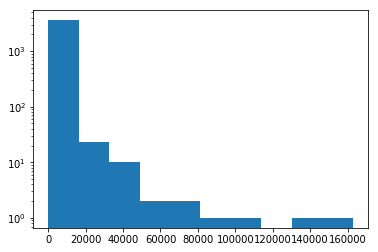

In [19]:
# Extract the new words into a list, then count the occurences
finalWordList = " ".join(final_sentences).split()
finalCounts = Counter(finalWordList)

## Convert counter to data frame and sort occurence
newwordcount = pd.DataFrame.from_dict(finalCounts, orient='index').reset_index()
newwordcount = newwordcount.rename(columns={'index':'word', 0:'count'})
## Sort in descending order of count and reset index
newwordcount = newwordcount.sort_values('count', ascending=False).reset_index(drop = True)
## Check it out
newwordcount.head()

# Build a word to frequency map
wordFreq_map = {}
## Generate new list using word as key and count as value
for record in range(0, (len(newwordcount))):
    word = newwordcount.iloc[record]['word']
    count = newwordcount.iloc[record]['count']
    wordFreq_map[word] = count
    
plt.hist(newwordcount['count'])
plt.yscale('log', nonposy='clip')
plt.show()

## Skip-Grams
Next, the unique words are indexed and our sentences are skip-grammed.

In [20]:
# Map words to indices
word2index_map = {}
index = 0
for sent in final_sentences:
    for word in sent.lower().split():
        if word not in word2index_map:
            word2index_map[word] = index
            index += 1
index2word_map = {index: word for word, index in word2index_map.items()}

vocabulary_size = len(index2word_map)

print("Vocab size:", vocabulary_size)
# print("Word Index:", index2word_map)

Vocab size: 3642


Inspect the top of the dictionary:

In [21]:
dict(list(index2word_map.items())[0:5])

{0: 'air', 1: 'cleaner', 2: 'band', 3: 'odx', 4: 'al'}

We will then generate skip-grams. The skip-gram window will start with the first word in a sentence and iterate through every word to the last in a sentence. The window size is parameterized. Skip-gram pairs are appended to a list.

In [22]:
# Initialize the skip-gram pairs list
skip_gram_pairs = []

# Set the skip-gram window size
window_size = 2

for sent in final_sentences:
    tokenized_sent = sent.split()
    # Set the target index
    for tgt_idx in range(0, len(tokenized_sent)):
        # Set range for the sentence
        max_idx = len(tokenized_sent) - 1

        # Define range around target
        lo_idx = max(tgt_idx - window_size, 0)
        hi_idx = min(tgt_idx + window_size, max_idx) + 1

        # List the indices in the skip-gram outputs (removing target index)
        number_list = range(lo_idx, hi_idx)
        output_matches = list(filter(lambda x: x != tgt_idx, number_list))

        # Generate skip-gram pairs
        pairs = [[word2index_map[tokenized_sent[tgt_idx]], word2index_map[tokenized_sent[out]]] for out in output_matches]
        # print(pairs)

        for p in pairs:
            skip_gram_pairs.append(p)

Inspect some skip-gram pairs to ensure the behavior is as expected:

In [23]:
skip_gram_pairs[0:12]

[[0, 1],
 [0, 2],
 [1, 0],
 [1, 2],
 [2, 0],
 [2, 1],
 [3, 4],
 [3, 5],
 [4, 3],
 [4, 5],
 [5, 3],
 [5, 4]]

For training, we will need to provide the neural network with batches of skip-gram pairs randomly sampled from our population. The next two blocks define the "get batch" function and print out a sample.

In [24]:
def get_skipgram_batch(batch_size):
    instance_indices = list(range(len(skip_gram_pairs)))
    np.random.shuffle(instance_indices)
    batch = instance_indices[:batch_size]
    x = [skip_gram_pairs[i][0] for i in batch]
    y = [[skip_gram_pairs[i][1]] for i in batch]
    return x, y

In [25]:
# batch example
x_batch, y_batch = get_skipgram_batch(8)
x_batch
y_batch
print("X Batch: ", [index2word_map[word] for word in x_batch])
print("Y Batch: ", [index2word_map[word[0]] for word in y_batch])

X Batch:  ['dump', 'spacer', 'kit', 'cabs', 'shell', 'harness', 'mx', 'lh']
Y Batch:  ['label', 'torque', 'tru', 'floor', 'fuel', 'cab', 'cab', 'assy']


## Training
The embeddings are trained in mini-batches. First, we define placeholders for the inputs and outputs of size batch_size:

In [35]:
batch_size = 64
embedding_dimension = 200
negative_samples = 8
n_iterations = 50000
LOG_DIR = "logs/word2vec_cab"

## ========= To Do Training ==================
Add the following features:
* Replace embedding with GPU-compatible method
* Decay training rate
* Downsample frequent terms
* Increase number of negative samples
* Work over full corpus, then count iterations of full corpus

## =========================================

In [27]:
# Input data, labels
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [28]:
# Embedding lookup table currently only implemented in CPU
with tf.name_scope("embeddings"):
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_dimension],
                          -1.0, 1.0), name='embedding')
    # This is essentialy a lookup table
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [29]:
# Create variables for the NCE loss
nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_dimension],
                            stddev=1.0 / math.sqrt(embedding_dimension)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))


loss = tf.reduce_mean(
  tf.nn.nce_loss(weights=nce_weights, biases=nce_biases, inputs=embed, labels=train_labels,
                 num_sampled=negative_samples, num_classes=vocabulary_size))
tf.summary.scalar("NCE_loss", loss)

<tf.Tensor 'NCE_loss:0' shape=() dtype=string>

In [30]:
# Learning rate decay
global_step = tf.Variable(0, trainable=False)
learningRate = tf.train.exponential_decay(learning_rate=0.1,
                                          global_step=global_step,
                                          decay_steps=1000,
                                          decay_rate=0.95,
                                          staircase=True)
train_step = tf.train.GradientDescentOptimizer(learningRate).minimize(loss)
merged = tf.summary.merge_all()

In [ ]:
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter(LOG_DIR,
                                         graph=tf.get_default_graph())
    saver = tf.train.Saver()

    with open(os.path.join(LOG_DIR, 'metadata.tsv'), "w") as metadata:
        metadata.write('Name\tClass\n')
        for k, v in index2word_map.items():
            metadata.write('%s\t%d\n' % (v, k))

    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embeddings.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
    projector.visualize_embeddings(train_writer, config)

    tf.global_variables_initializer().run()

    for step in range(n_iterations):
        x_batch, y_batch = get_skipgram_batch(batch_size)
        summary, _ = sess.run([merged, train_step],
                              feed_dict={train_inputs: x_batch,
                                         train_labels: y_batch})
        train_writer.add_summary(summary, step)

        if step % 100 == 0:
            saver.save(sess, os.path.join(LOG_DIR, "w2v_model.ckpt"), step)
            loss_value = sess.run(loss,
                                  feed_dict={train_inputs: x_batch,
                                             train_labels: y_batch})
            print("Loss at %d: %.5f" % (step, loss_value))

    # Normalize embeddings before using
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    normalized_embeddings_matrix = sess.run(normalized_embeddings)

Loss at 0: 41.58869
Loss at 100: 26.10132
Loss at 200: 21.87313
Loss at 300: 24.23152
Loss at 400: 35.83926
Loss at 500: 23.49591
Loss at 600: 30.70482
Loss at 700: 26.82783
Loss at 800: 28.28434
Loss at 900: 32.30779
Loss at 1000: 40.14656
Loss at 1100: 26.79992
Loss at 1200: 17.51442
Loss at 1300: 25.06448
Loss at 1400: 29.84503
Loss at 1500: 22.49715
Loss at 1600: 12.65254
Loss at 1700: 23.18967
Loss at 1800: 8.83474
Loss at 1900: 9.50443
Loss at 2000: 17.14473
Loss at 2100: 18.74365
Loss at 2200: 30.40864
Loss at 2300: 12.53049
Loss at 2400: 20.42619
Loss at 2500: 10.59704
Loss at 2600: 20.67228
Loss at 2700: 21.12312
Loss at 2800: 16.37489
Loss at 2900: 27.39848
Loss at 3000: 9.10460
Loss at 3100: 19.56289
Loss at 3200: 24.15853
Loss at 3300: 1.68069
Loss at 3400: 12.01098
Loss at 3500: 9.11979
Loss at 3600: 11.17490


'/home/dannygodbout/Projects/CloudCAB/Code'

In [ ]:
ref_word = normalized_embeddings_matrix[word2index_map["one"]]

cosine_dists = np.dot(normalized_embeddings_matrix, ref_word)
ff = np.argsort(cosine_dists)[::-1][1:10]
for f in ff:
    print(index2word_map[f])
    print(cosine_dists[f])

## Tensorboard Visualization
To see a visualization of the word vectors, open a Tensorboard session and navigate to the "Projector" tab. 

To start a tensorflow session, run the following command in a terminal (make sure you're in the correct Python virtual env):
```
tensorboard --logdir=c:\DataScience\CloudCAB\Code\logs
```
Alternatively, a "Start_Tensorboard" bat file has been placed in the root directory of this repo.

NOTE: On windows systems, the path to your metadata.tsv file for embeddings may be incorrect, resulting in an error when trying to plot embeddings in Tensorboard. To fix this, edit the logs/word2vec_intro/projector_config.pbtxt file as follows:
* Examine the path listed in the error message in Tensorboard. It will likely have your log path duplicated.
* Remove the duplicate portion of the path from the metadata_path value in projector_config
* Restart Tensorboard and re-try plotting